## EVs Power Consumption 1 Day Forecast - 1 Station in Colorado - 15min Resolution

### Libraries

In [1]:
import os
import yaml
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns
import holidays
import itertools
import missingno as msno
import warnings
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, make_scorer
from sklearn.metrics import confusion_matrix, jaccard_score, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from deep_model import DeepModelTS
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge, Lasso
from matplotlib.dates import DateFormatter, AutoDateLocator
from datetime import datetime
from datetime import timedelta

warnings.filterwarnings('ignore')
pd.reset_option('display.max_rows')

### Plot Parameters

In [48]:
plt.rcParams['figure.figsize']= (10, 5)
plt.style.use('tableau-colorblind10')
plt.rcParams.update({'font.size': 10})
pd.set_option('display.max_columns', None)
date_format = DateFormatter('%H:%M') 

### Auxiliary Functions

In [3]:
#Function define_season

"""
Gives the number of the season based on the month 
    
Args:
    month_number
        
Returns:
    1 - Winter
    2 - Spring
    3 - Summer
    4 - Fall
"""

def define_season(month_number):
    if month_number in [12,1,2]:
        return 1
    
    elif month_number in [3,4,5]:
        return 2
    
    elif month_number in [6,7,8]:
        return 3
    
    elif month_number in [9,10,11]:
        return 4

In [4]:
# Function create_features

"""
Creates date/time features from a dataframe 
    
Args:
    df - dataframe with a datetime index
        
Returns:
    df - dataframe with 'Weekofyear','Dayofyear','Month','Dayofmonth',
                        'Dayofweek','Weekend','Season','Holiday','Hour' and 'Minute' features created
"""

def create_features(df):
    
    df['Date'] = df.index
    df['Weekofyear'] = df['Date'].dt.isocalendar().week   #Value: 1-52
    df['Dayofyear'] = df['Date'].dt.dayofyear    #Value: 1-365
    df['Month'] = df['Date'].dt.month   #Value: 1-12
    df['Dayofmonth'] = df['Date'].dt.day   #Value: 1-30/31
    df['Dayofweek'] = df['Date'].dt.weekday+1     #Value: 1-7 (Monday-Sunday)
    df['Weekend'] = np.where((df['Dayofweek'] == 6) | (df['Dayofweek'] == 7), 1, 0)    #Value: 1 if weekend, 0 if not
    df['Season'] = df.Month.apply(define_season)    #Value 1-4 (winter, spring, summer and fall)
    df['Hour'] = df['Date'].dt.hour
    df['Hour'] = (df['Hour']+24).where(df['Hour'] == 0, df['Hour'])    #Value: 1-24
    df = df.drop(['Date'], axis=1)
    
    return df

In [5]:
# Function lag_features

"""
Creates lag features from a dataframe
    
Args:
    lag_dataset - dataframe 
    days_list - list with the number of days to lag
    var - name of the column to lag (target variable)
        
Returns:
    lag_dataset - dataframe with lag_consumption and mean_rolling features created
"""

def lag_features(lag_dataset, days_list, var):
    
    temp_data = lag_dataset[var]

    for days in days_list:
        period = 96 * days
        lag_dataset[var + "_lag_{}".format(days)] = temp_data.shift(period)

    return lag_dataset 

In [6]:
# Function cyclical_features

"""
Transforms (date/time) features into cyclical sine and cosine features
    
Args:
    df - dataframe with 'Weekofyear','Dayofyear','Season','Month',
                        'Dayofmonth','Dayofweek','Hour','Minute' columns
        
Returns:
    df - dataframe including the cyclical features (x and y for each column)
"""

def cyclical_features(df):

    df['Weekofyear_x']= np.cos(df['Weekofyear']*2*np.pi/53)
    df['Weekofyear_y']= np.sin(df['Weekofyear']*2*np.pi/53)
    df['Dayofyear_x']= np.cos(df['Dayofyear']*2*np.pi/365)
    df['Dayofyear_y']= np.sin(df['Dayofyear']*2*np.pi/365)
    df['Season_x']= np.cos(df['Season']*2*np.pi/4)
    df['Season_y']= np.sin(df['Season']*2*np.pi/4)
    df['Month_x']= np.cos(df['Month']*2*np.pi/12)
    df['Month_y']= np.sin(df['Month']*2*np.pi/12)
    df['Dayofmonth_x']= np.cos(df['Dayofmonth']*2*np.pi/31)
    df['Dayofmonth_y']= np.sin(df['Dayofmonth']*2*np.pi/31)
    df['Dayofweek_x']= np.cos(df['Dayofweek']*2*np.pi/7)
    df['Dayofweek_y']= np.sin(df['Dayofweek']*2*np.pi/7)
    df['Hour_x']= np.cos(df['Hour']*2*np.pi/24)
    df['Hour_y']= np.sin(df['Hour']*2*np.pi/24)
    
    df= df.drop(columns=['Weekofyear','Dayofyear','Season','Month','Dayofmonth',
                                         'Dayofweek','Hour'])
    
    return df

In [7]:
# Function compute_errors

"""
Calculates the metrics to measure the perfomance of the forecasting models
    
Args:
    df - dataframe with 'Prediction' and 'Real' columns
    val - value used to normalized 
        
Returns:
    MAE - mean absolute error
    RMSE - root mean square error
    normRMSE - normalized root mean square error
    R2 - coefficient of determination
"""

def compute_errors(df, val):

    MAE = metrics.mean_absolute_error(df.Real, df.Prediction)
    RMSE = np.sqrt(metrics.mean_squared_error(df.Real, df.Prediction))
    normRMSE = 100 * RMSE / val
    R2 = metrics.r2_score(df.Real, df.Prediction)
    
    return MAE, RMSE, normRMSE, R2

In [63]:
# Function result_plots

"""
Creates the plots to compare the real values with the predictions obtained
    
Args:
    df - dataframe with 'Prediction' and 'Real' columns
    model_name - string with the name of the model that will appear in the title of the plots
        
Returns:
    Two plots showed
"""

def result_plots(df, model_name):

    # Regression Plot
    sns.scatterplot(data= df, x= 'Real', y= 'Prediction', s=40)
    plt.plot(df.Real, df.Real, color = "red", linewidth= 1) 
    plt.xlabel("Real Power (kW)", alpha= 0.75, weight= "bold")
    plt.ylabel("Predicted Power (kW)", alpha= 0.75, weight= "bold")
    plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
    plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
    plt.title(f"Correlation real vs predicted for {model_name}", alpha= 0.75, weight= "bold", pad= 10, loc= "left")
    plt.xlim(0,7)
    plt.ylim(0,7)
    plt.show()

    # Real vs predictions in the same plot
    fig, ax = plt.subplots()
    sns.lineplot(x= df.index, y= df.Real, label= "Real", ax= ax, linestyle = "dashed")
    sns.lineplot(x= df.index, y= df.Prediction, label= "Predicted", ax= ax, linewidth = 0.5)
    plt.xlabel("Date", alpha= 0.75, weight= "bold")
    plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
    plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
    plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
    plt.legend(frameon= False, bbox_to_anchor=(1.17, 1))
    plt.title(f"Real vs predicted PV power production using {model_name}", alpha= 0.75, weight= "bold", pad= 10, loc= "left")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.ylim(0,7)
    plt.show()

In [9]:
# Function plot_confusion_matrix

"""
Prints and plots the confusion matrix
Normalization can be applied by setting 'normalize=True'
"""
    
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, alpha= 0.75, weight= "bold")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, alpha= 0.75,weight= "bold", rotation=45)
    plt.yticks(tick_marks, classes, alpha= 0.75, weight= "bold",)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', alpha= 0.75, weight= "bold")
    plt.xlabel('Predicted label',  alpha= 0.75, weight= "bold")

In [10]:
# Function hms_to_minutes

"""
Converts hh:mm:ss to minutes (int)
"""

def hms_to_minutes(hms_string):
    
    hours, minutes, seconds = map(int, hms_string.split(':'))
    total_minutes = round(hours * 60 + minutes + seconds / 60, 0)
    
    return total_minutes

### Reading the data (EVs Charging Sessions)

In [11]:
data = pd.read_csv('./Datasets/Colorado Boulder New.csv')

# Choosing just one station of Colorado city
station = 'BOULDER / N BOULDER REC 1' 
data = data[(data.Station_Name == station) & (data.Energy__kWh_ > 0)]
data= data[['Start_Date___Time','End_Date___Time','Energy__kWh_','Total_Duration__hh_mm_ss_','Charging_Time__hh_mm_ss_','Station_Name']]

data

Start_Date___Time         End_Date___Time  Energy__kWh_  \
3268   2018/08/23 08:26:00+00  2018/08/23 09:34:00+00         2.182   
3287   2018/08/23 15:38:00+00  2018/08/23 17:08:00+00         2.555   
3301   2018/08/24 08:10:00+00  2018/08/24 08:26:00+00         0.858   
3302   2018/08/24 08:27:00+00  2018/08/24 08:43:00+00         0.641   
3496   2018/08/22 08:39:00+00  2018/08/22 11:00:00+00         5.526   
...                       ...                     ...           ...   
62294  2023/05/06 18:02:00+00  2023/05/06 23:50:00+00        37.783   
62314  2023/05/06 08:16:00+00  2023/05/06 10:35:00+00        14.237   
62349  2023/05/05 09:03:00+00  2023/05/05 13:39:00+00        19.607   
62365  2023/05/06 10:51:00+00  2023/05/06 12:22:00+00         9.964   
62373  2023/05/06 12:29:00+00  2023/05/06 16:59:00+00        21.091   

      Total_Duration__hh_mm_ss_ Charging_Time__hh_mm_ss_  \
3268                    1:07:50                  0:49:25   
3287                    1:30:09                  1:28:23   
3301                    0:16:07                  0:15:44   
3302                    0:15:51                  0:15:39   
3496                    2:21:29                  2:21:08   
...                         ...                      ...   
62294                   5:47:36                  5:47:20   
62314                   2:18:10                  2:17:58   
62349                   4:35:35                  4:04:11   
62365                   1:30:59                  1:30:34   
62373                   4:29:37                  4:29:18   

                    Station_Name  
3268   BOULDER / N BOULDER REC 1  
3287   BOULDER / N BOULDER REC 1  
3301   BOULDER / N BOULDER REC 1  
3302   BOULDER / N BOULDER REC 1  
3496   BOULDER / N BOULDER REC 1  
...                          ...  
62294  BOULDER / N BOULDER REC 1  
62314  BOULDER / N BOULDER REC 1  
62349  BOULDER / N BOULDER REC 1  
62365  BOULDER / N BOULDER REC 1  
62373  BOULDER / N BOULDER REC 1  

[6508 rows x 6 columns]

### Pre-Processing and Feature Engineering

#### Transforming sessions into Plug and Energy timeseries

In [12]:
# Selecting the necessary information from the data and transforming charging and total time to minutes
df= pd.DataFrame()
df['Start'] = pd.to_datetime(data['Start_Date___Time'].apply(lambda x: pd.Series(str(x).split("+"))[0]))
# df['End'] = pd.to_datetime(data['End_Date___Time'].apply(lambda x: pd.Series(str(x).split("+"))[0]))
df['Charging_Time'] = data['Charging_Time__hh_mm_ss_'].apply(hms_to_minutes)
df['Total_Time'] = data['Total_Duration__hh_mm_ss_'].apply(hms_to_minutes)
df['Energy'] = data['Energy__kWh_']
df.sort_values('Start', inplace= True)
df.reset_index(inplace= True, drop= True)

print(f'Total number of charging sessions: {len(df)}')
df

Total number of charging sessions: 6508


Start  Charging_Time  Total_Time  Energy
0    2018-08-22 08:39:00          141.0       141.0   5.526
1    2018-08-22 09:46:00          115.0       264.0   6.362
2    2018-08-22 16:09:00           63.0        64.0   3.020
3    2018-08-23 08:26:00           49.0        68.0   2.182
4    2018-08-23 15:38:00           88.0        90.0   2.555
...                  ...            ...         ...     ...
6503 2023-06-01 07:47:00          128.0       128.0  11.849
6504 2023-06-01 14:14:00           52.0        52.0   5.020
6505 2023-06-01 14:54:00           69.0        77.0   2.106
6506 2023-06-01 15:27:00           83.0        84.0   6.943
6507 2023-06-01 16:37:00           53.0        53.0   4.984

[6508 rows x 4 columns]

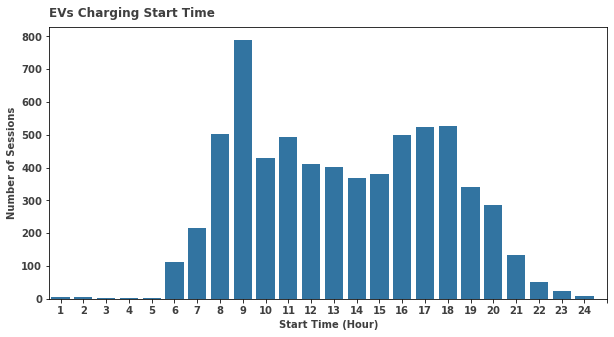

In [13]:
# Plot of number of sessions per hour
df_start = df.copy()
df_start['Hour'] = (df_start['Start'].dt.hour)+1

df_start = df_start.groupby(df_start['Hour']).count()
sns.barplot(data= df_start, x= df_start.index, y= 'Start', color= '#1f77b4')
plt.xticks(range(0,25), alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Start Time (Hour)", alpha= 0.75, weight= "bold")
plt.ylabel("Number of Sessions", alpha= 0.75, weight= "bold")
plt.title("EVs Charging Start Time", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

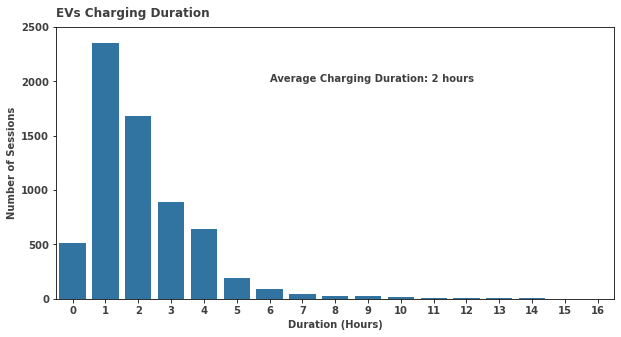

In [14]:
# Plot of number of sessions per charging duration
df_duration = df.copy()
df_duration['Duration'] = round(df_duration['Charging_Time']/60, 0)
avg_duration = int(df_duration['Duration'].mean())

df_duration = df_duration.groupby(df_duration['Duration']).count()
df_duration.index = map(int, df_duration.index)
sns.barplot(data= df_duration, x= df_duration.index, y= 'Charging_Time', color= '#1f77b4')
plt.annotate(f'Average Charging Duration: {avg_duration} hours', xy=(6, 2000), alpha= 0.75, weight= "bold")

plt.xticks(alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Duration (Hours)", alpha= 0.75, weight= "bold")
plt.ylabel("Number of Sessions", alpha= 0.75, weight= "bold")
plt.title("EVs Charging Duration", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.ylim(0,2500)
plt.show()

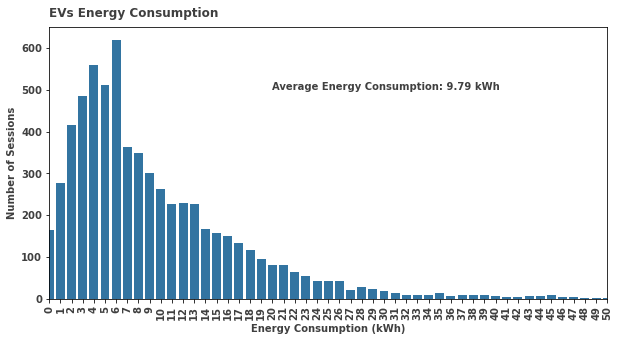

In [15]:
# Plot of number of sessions per energy consumption
df_energy = df.copy()
avg_energy = round(df_energy['Energy'].mean(), 2)
df_energy['Energy'] = round(df_energy['Energy'], 0)

df_energy = df_energy.groupby(df_energy['Energy']).count()
df_energy.index = map(int, df_energy.index)
sns.barplot(data= df_energy, x= df_energy.index, y= 'Start', color= '#1f77b4')
plt.annotate(f'Average Energy Consumption: {avg_energy} kWh', xy=(20, 500), alpha= 0.75, weight= "bold")

plt.xlim(0, 50)
plt.xticks(alpha= 0.75, weight= "bold", rotation= 90)
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Energy Consumption (kWh)", alpha= 0.75, weight= "bold")
plt.ylabel("Number of Sessions", alpha= 0.75, weight= "bold")
plt.title("EVs Energy Consumption", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

In [16]:
%%time
# Generating the plug and energy for each session
df2 = pd.DataFrame()
for row in df.itertuples(index= False):
    df_plug = pd.DataFrame(index= pd.date_range(start= row[0], end= row[0] + timedelta(minutes= row[1]), freq='1min'))
    df_plug['Plug'] = 1
    df_plug['Energy'] = row[3] / len(df_plug)
    df2 = pd.concat([df2, df_plug])
    
    if row[1] != row[2]:
        df_un = pd.DataFrame(index= pd.date_range(start= row[0] + timedelta(minutes= row[1] + 1), end= row[0] + timedelta(minutes= row[1] + row[2]), freq='1min'))
        df_un['Plug'] = 0
        df_un['Energy'] = 0
        df2 = pd.concat([df2, df_un])

# Looking duplicate timestamps
duplicates = df2.loc[df2.index.duplicated(keep=False)].sort_index()

duplicates 

Wall time: 2min 35s


Plug    Energy
2018-08-22 09:46:00     1  0.038915
2018-08-22 09:46:00     1  0.054845
2018-08-22 09:47:00     1  0.054845
2018-08-22 09:47:00     1  0.038915
2018-08-22 09:48:00     1  0.038915
...                   ...       ...
2023-06-01 17:28:00     1  0.092296
2023-06-01 17:29:00     0  0.000000
2023-06-01 17:29:00     1  0.092296
2023-06-01 17:30:00     0  0.000000
2023-06-01 17:30:00     1  0.092296

[855250 rows x 2 columns]

In [17]:
# Adding the energy of the duplicates and updating the plug
df2 = df2.groupby(by= df2.index).agg({'Plug': 'max', 'Energy': 'mean'})
df2.sort_index(inplace= True)

# Generating the rest of timestamps missing and assigning a 0
index_full= pd.DataFrame(index= pd.date_range(start= df2.index[0], end= df2.index[-1], freq='1min'))
df_final = index_full.join(df2)
df_final.fillna(0, inplace= True)
df_final['Plug'] = df_final['Plug'].astype(int) 
df_final.index.name='Date'

df_final

Plug    Energy
Date                               
2018-08-22 08:39:00     1  0.038915
2018-08-22 08:40:00     1  0.038915
2018-08-22 08:41:00     1  0.038915
2018-08-22 08:42:00     1  0.038915
2018-08-22 08:43:00     1  0.038915
...                   ...       ...
2023-06-01 18:10:00     0  0.000000
2023-06-01 18:11:00     0  0.000000
2023-06-01 18:12:00     0  0.000000
2023-06-01 18:13:00     0  0.000000
2023-06-01 18:14:00     0  0.000000

[2511936 rows x 2 columns]

#### Defining the data to use, transforming energy into power and resampling to 15min resolution

In [18]:
data_final = df_final
data_final['Power'] = round(data_final.Energy * 4, 2)
data_final.drop(['Energy'], axis= 1, inplace= True)
data_final = data_final.resample('15min').agg({'Plug': 'max', 'Power': 'sum'})
data_final

Plug  Power
Date                            
2018-08-22 08:30:00     1   0.96
2018-08-22 08:45:00     1   2.40
2018-08-22 09:00:00     1   2.40
2018-08-22 09:15:00     1   2.40
2018-08-22 09:30:00     1   2.40
...                   ...    ...
2023-06-01 17:00:00     1   1.80
2023-06-01 17:15:00     1   2.34
2023-06-01 17:30:00     1   0.18
2023-06-01 17:45:00     0   0.00
2023-06-01 18:00:00     0   0.00

[167463 rows x 2 columns]

#### Missing Data

In [19]:
# Number of missing values
percent_missing = round(data_final.isna().sum()* 100 / len(data_final), 1)
print(f'% of missing values in the dataset \n {percent_missing}')

# Delete rows with NaN values
data_final.dropna(axis= 0, inplace= True)

% of missing values in the dataset 
 Plug     0.0
Power    0.0
dtype: float64


#### Descriptive Statistics

In [20]:
data_final.describe()

Plug          Power
count  167463.000000  167463.000000
mean        0.300520       1.095008
std         0.458486       1.911117
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         1.000000       1.950000
max         1.000000       6.600000

#### Creating features

In [21]:
%%time
# Creating date/time features using the datetime index
data_final = create_features(data_final)

data_final

Wall time: 394 ms


Plug  Power  Weekofyear  Dayofyear  Month  Dayofmonth  \
Date                                                                         
2018-08-22 08:30:00     1   0.96          34        234      8          22   
2018-08-22 08:45:00     1   2.40          34        234      8          22   
2018-08-22 09:00:00     1   2.40          34        234      8          22   
2018-08-22 09:15:00     1   2.40          34        234      8          22   
2018-08-22 09:30:00     1   2.40          34        234      8          22   
...                   ...    ...         ...        ...    ...         ...   
2023-06-01 17:00:00     1   1.80          22        152      6           1   
2023-06-01 17:15:00     1   2.34          22        152      6           1   
2023-06-01 17:30:00     1   0.18          22        152      6           1   
2023-06-01 17:45:00     0   0.00          22        152      6           1   
2023-06-01 18:00:00     0   0.00          22        152      6           1   

                     Dayofweek  Weekend  Season  Hour  
Date                                                   
2018-08-22 08:30:00          3        0       3     8  
2018-08-22 08:45:00          3        0       3     8  
2018-08-22 09:00:00          3        0       3     9  
2018-08-22 09:15:00          3        0       3     9  
2018-08-22 09:30:00          3        0       3     9  
...                        ...      ...     ...   ...  
2023-06-01 17:00:00          4        0       3    17  
2023-06-01 17:15:00          4        0       3    17  
2023-06-01 17:30:00          4        0       3    17  
2023-06-01 17:45:00          4        0       3    17  
2023-06-01 18:00:00          4        0       3    18  

[167463 rows x 10 columns]

In [22]:
%%time
# Creating lag features for 1 day, 5 days and 1 week before
data_final = lag_features(data_final,[1,5,7], 'Power')
data_final.fillna(0, inplace= True)

data_final

Wall time: 32.7 ms


Plug  Power  Weekofyear  Dayofyear  Month  Dayofmonth  \
Date                                                                         
2018-08-22 08:30:00     1   0.96          34        234      8          22   
2018-08-22 08:45:00     1   2.40          34        234      8          22   
2018-08-22 09:00:00     1   2.40          34        234      8          22   
2018-08-22 09:15:00     1   2.40          34        234      8          22   
2018-08-22 09:30:00     1   2.40          34        234      8          22   
...                   ...    ...         ...        ...    ...         ...   
2023-06-01 17:00:00     1   1.80          22        152      6           1   
2023-06-01 17:15:00     1   2.34          22        152      6           1   
2023-06-01 17:30:00     1   0.18          22        152      6           1   
2023-06-01 17:45:00     0   0.00          22        152      6           1   
2023-06-01 18:00:00     0   0.00          22        152      6           1   

                     Dayofweek  Weekend  Season  Hour  Power_lag_1  \
Date                                                                 
2018-08-22 08:30:00          3        0       3     8          0.0   
2018-08-22 08:45:00          3        0       3     8          0.0   
2018-08-22 09:00:00          3        0       3     9          0.0   
2018-08-22 09:15:00          3        0       3     9          0.0   
2018-08-22 09:30:00          3        0       3     9          0.0   
...                        ...      ...     ...   ...          ...   
2023-06-01 17:00:00          4        0       3    17          0.0   
2023-06-01 17:15:00          4        0       3    17          3.3   
2023-06-01 17:30:00          4        0       3    17          4.5   
2023-06-01 17:45:00          4        0       3    17          4.5   
2023-06-01 18:00:00          4        0       3    18          4.5   

                     Power_lag_5  Power_lag_7  
Date                                           
2018-08-22 08:30:00         0.00         0.00  
2018-08-22 08:45:00         0.00         0.00  
2018-08-22 09:00:00         0.00         0.00  
2018-08-22 09:15:00         0.00         0.00  
2018-08-22 09:30:00         0.00         0.00  
...                          ...          ...  
2023-06-01 17:00:00         4.57         2.25  
2023-06-01 17:15:00         4.65         2.40  
2023-06-01 17:30:00         4.65         2.40  
2023-06-01 17:45:00         4.65         2.40  
2023-06-01 18:00:00         4.35         2.40  

[167463 rows x 13 columns]

#### Exploratory Data Analysis (Plots)

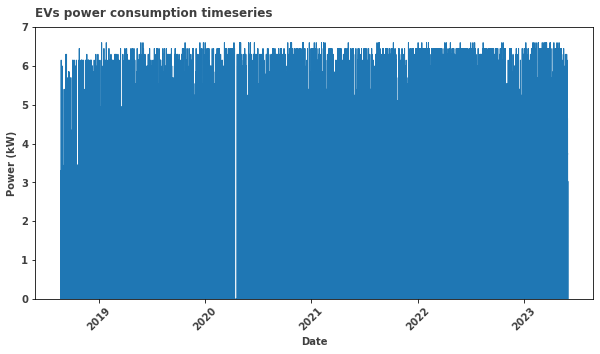

In [23]:
# Plot of power timeseries
plt.plot(data_final.index, data_final.Power, linewidth= 1, color= '#1f77b4')
plt.xlabel("Date", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75, weight= "bold", rotation = 45)
plt.yticks(alpha= 0.75, weight= "bold")
plt.ylim(0,7)
plt.title("EVs power consumption timeseries", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

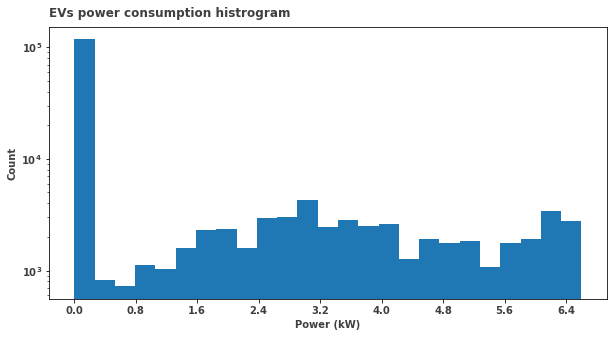

In [24]:
# Histogram of power
fig, ax = plt.subplots()
plt.hist(data_final.Power, bins= 25, log= True, color= '#1f77b4')
plt.xticks(alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.ylabel("Count", alpha= 0.75, weight= "bold")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.title("EVs power consumption histrogram", alpha=0.75, weight="bold", loc="left", pad=10)
plt.show()

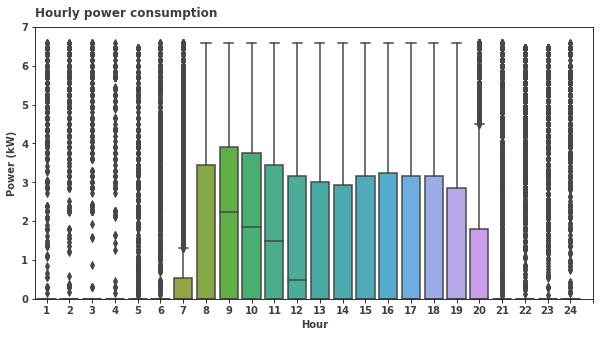

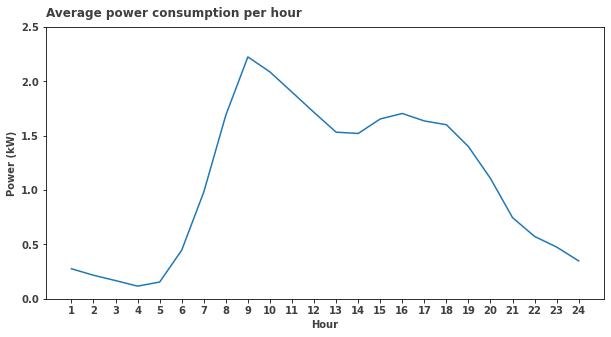

In [25]:
# Hourly power consumption scatterplot
sns.boxplot(data= data_final, x= 'Hour', y= 'Power')
plt.xticks(range(0,25), alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.ylim(0,7)
plt.xlabel("Hour", alpha=0.75, weight="bold")
plt.ylabel("Power (kW)", alpha=0.75, weight= "bold")
plt.title("Hourly power consumption", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

# Average consumption per hour barplot
sns.lineplot(data= data_final, x= 'Hour', y= 'Power', ci= None, color= '#1f77b4')
plt.xticks(range(1,25), alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.ylim(0,2.5)
plt.xlabel("Hour", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.title("Average power consumption per hour", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

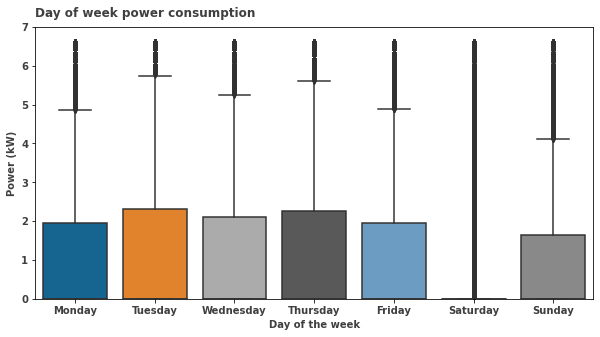

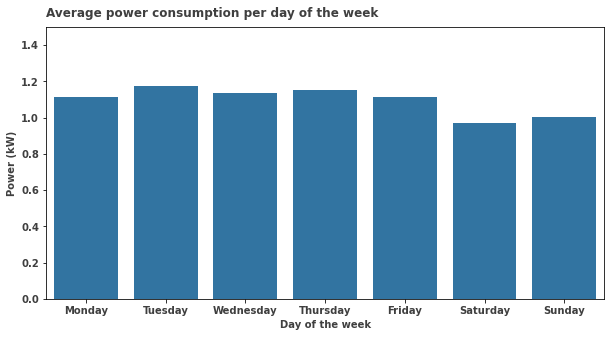

In [26]:
# Day of the week power consumption scatterplot
sns.boxplot(data= data_final, x= 'Dayofweek', y= 'Power')
plt.xticks(range(0,7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Day of the week", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.ylim(0,7)
plt.title("Day of week power consumption", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

# Average consumption per day of the week barplot
sns.barplot(data= data_final, x= 'Dayofweek', y= 'Power', ci= None, color= '#1f77b4')
plt.xticks(range(0,7), ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"], alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Day of the week", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.ylim(0,1.5)
plt.title("Average power consumption per day of the week", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

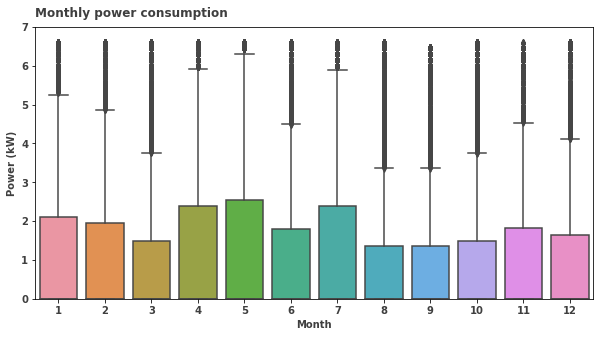

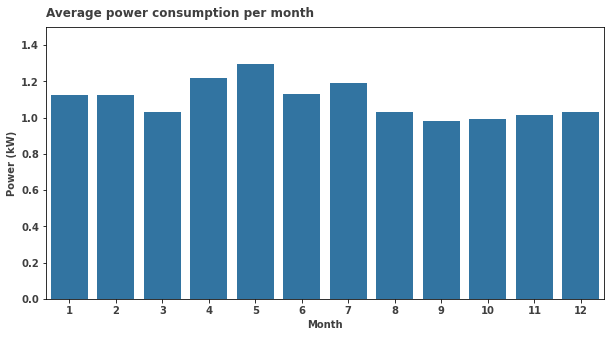

In [27]:
# Monthly power consumption scatterplot
fig, ax= plt.subplots()
sns.boxplot(data= data_final, x= 'Month', y= 'Power')
plt.xticks(range(0,12), alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Month", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.ylim(0,7)
plt.title("Monthly power consumption", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

# Average consumption per month barplot
sns.barplot(data= data_final, x= 'Month', y= 'Power', ci= None, color= '#1f77b4')
plt.xticks(range(0,12), alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Month", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.ylim(0,1.5)
plt.title("Average power consumption per month", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

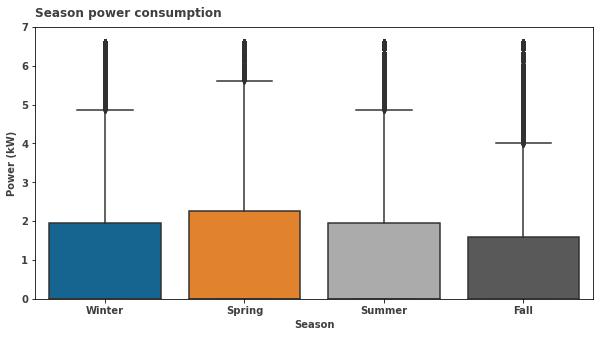

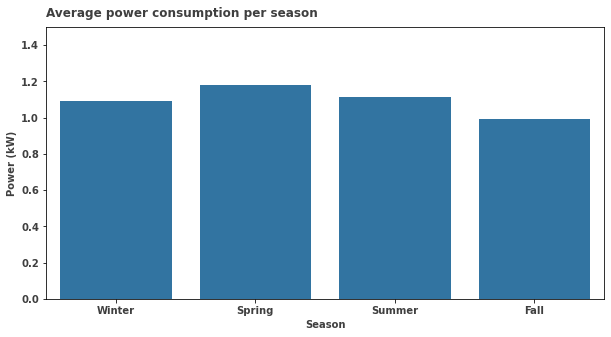

In [28]:
# Season power consumption scatterplot
sns.boxplot(data= data_final, x= 'Season', y= 'Power')
plt.xticks(range(0,4),['Winter', 'Spring', 'Summer','Fall'], alpha=0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Season", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight ="bold")
plt.ylim(0,7)
plt.title("Season power consumption", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

# Average consumption per season barplot
sns.barplot(data= data_final, x= 'Season', y= 'Power', ci= None, color= '#1f77b4')
plt.xticks(range(0,4),['Winter', 'Spring', 'Summer','Fall'], alpha=0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Season", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.ylim(0,1.5)
plt.title("Average power consumption per season", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

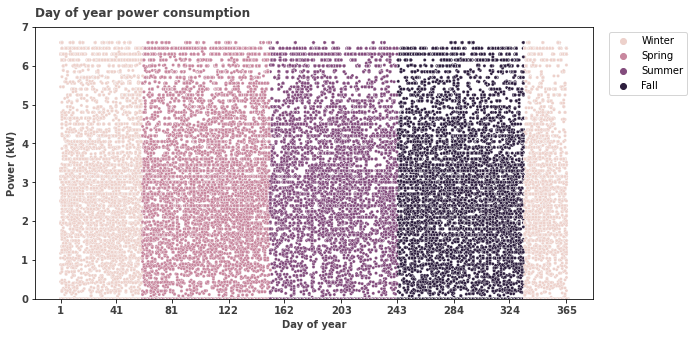

In [29]:
# Day of the year power consumption scatterplot
fig, ax= plt.subplots()
sns.scatterplot(data= data_final, x= 'Dayofyear', y= 'Power', hue= 'Season', s= 10)
x_thicks= np.asarray(np.linspace(1, 365, 10), dtype= 'int')
plt.xticks(x_thicks, alpha= 0.75, weight= "bold") 
plt.yticks(alpha= 0.75, weight= "bold")
plt.xlabel("Day of year", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.ylim(0,7)
handles, labels = plt.gca().get_legend_handles_labels()
legend_labels = dict(zip(handles, ['Winter', 'Spring', 'Summer','Fall']))
plt.legend(handles, [legend_labels[h] for h in handles], loc= 'upper left', bbox_to_anchor=(1.02, 1))
plt.title("Day of year power consumption", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

### Clustering

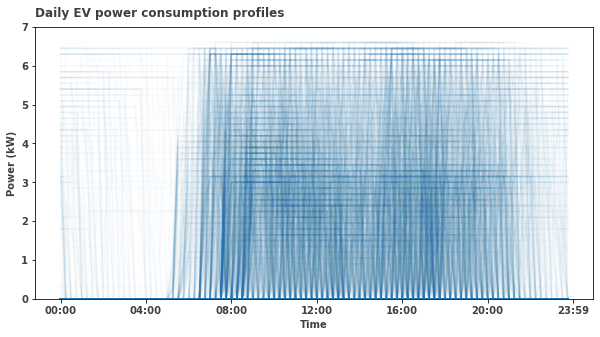

In [50]:
# Identifying daily patterns of EV power consumption
times = ['00:00', '04:00', '08:00', '12:00', '16:00', '20:00', '23:59']
df_clusters = data_final.copy()
df_clusters['Time'] = df_clusters.index.time
df_clusters = df_clusters.loc[:,['Power', 'Time']]
df_clusters.reset_index(inplace=True)
df_clusters['Date'] = df_clusters['Date'].dt.date

df_pivot = df_clusters.pivot_table(index= 'Date', columns= 'Time', values= 'Power')
df_pivot.fillna(0, inplace= True)
df_pivot.T.plot(legend= False, color= '#1f77b4', alpha= 0.02)
plt.xlabel('Time', alpha= 0.75, weight="bold")
plt.xticks(times, alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.ylim(0,7)
plt.ylabel('Power (kW)', alpha= 0.75, weight= "bold")
plt.title('Daily EV power consumption profiles', alpha= 0.75, weight= "bold", loc= "left", pad= 10) 
plt.show()

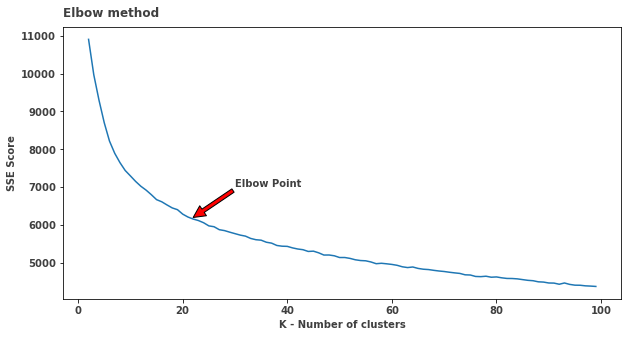

Wall time: 2min 28s


In [31]:
%%time
# Defining optimal number of clusters
X = df_pivot.values.copy() 
sc = MinMaxScaler()
X = sc.fit_transform(X)

n_cluster_list = np.arange(2,100).astype(int)

distortions = []

for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters= n_cluster, init= 'k-means++', max_iter= 100, random_state= 0)
    kmeans.fit_predict(X)
    distortions.append(kmeans.inertia_)

plt.plot(n_cluster_list, distortions, color= '#1f77b4')
plt.title('Elbow method', alpha=0.75, weight= "bold", loc= "left", pad= 10) 
plt.annotate('Elbow Point', xy=(22, 6200), xytext=(30, 7000), arrowprops=dict(facecolor='red'), alpha= 0.75, weight= "bold")
plt.xlabel('K - Number of clusters', alpha= 0.75, weight= "bold")
plt.ylabel('SSE Score', alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.show()

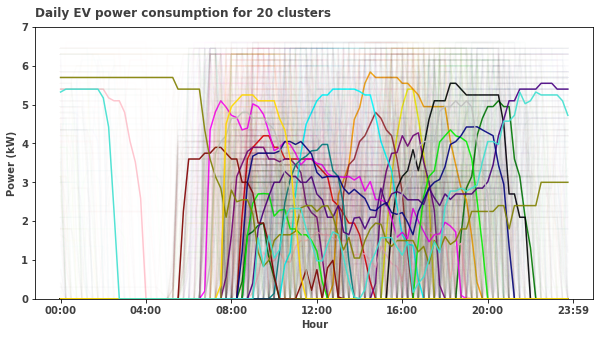

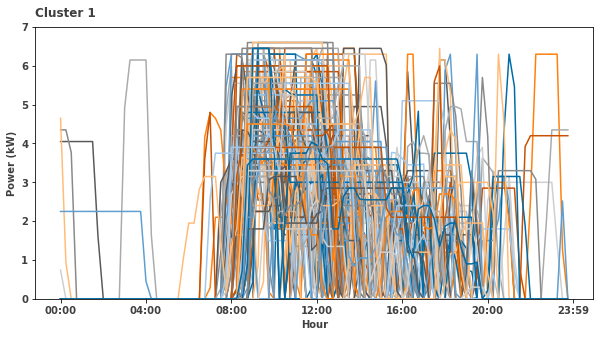

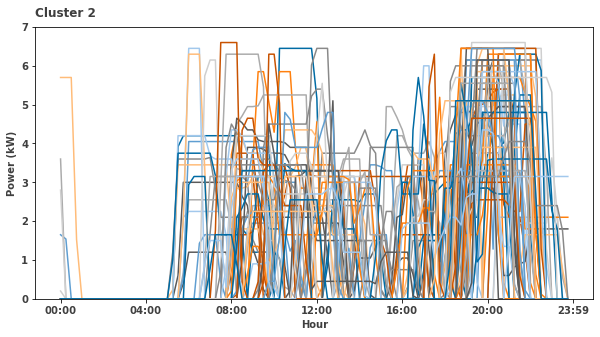

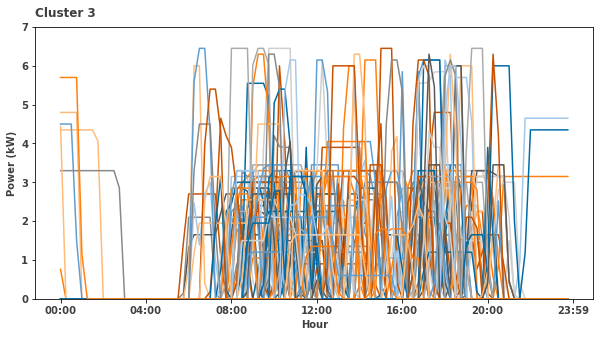

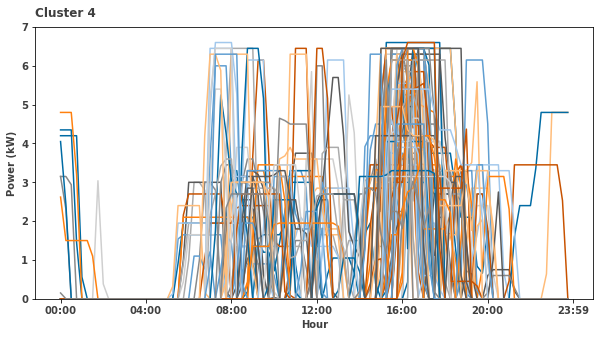

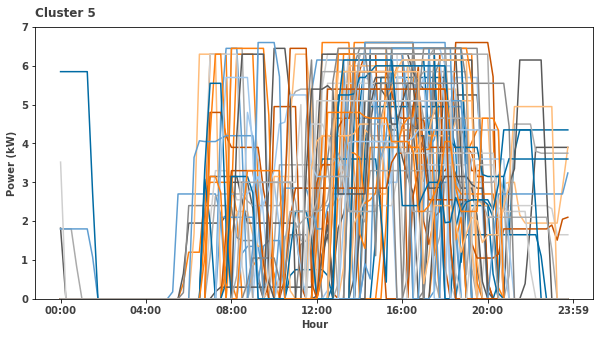

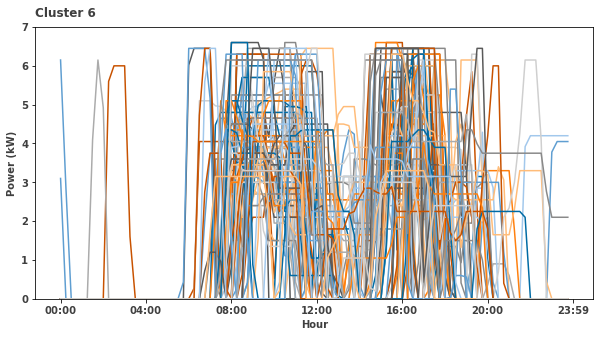

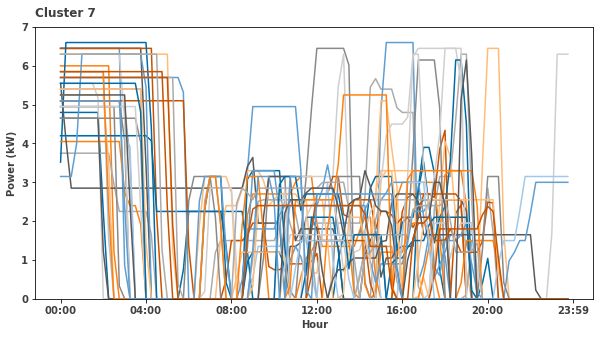

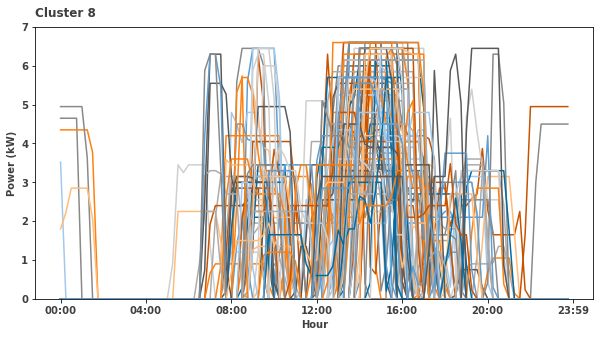

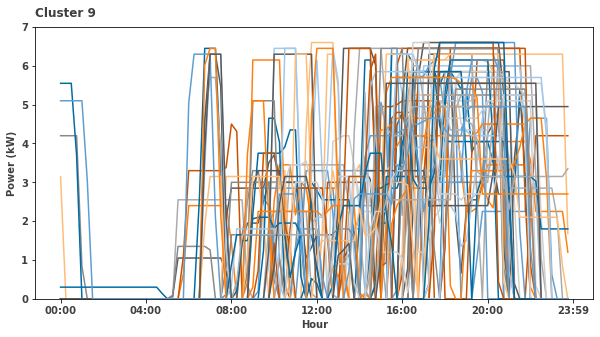

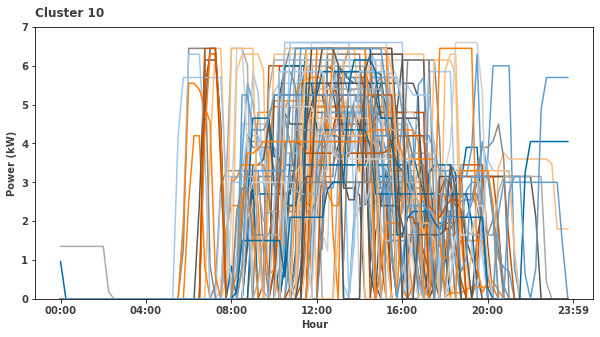

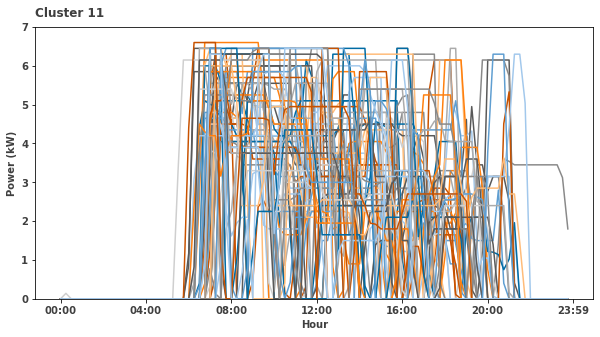

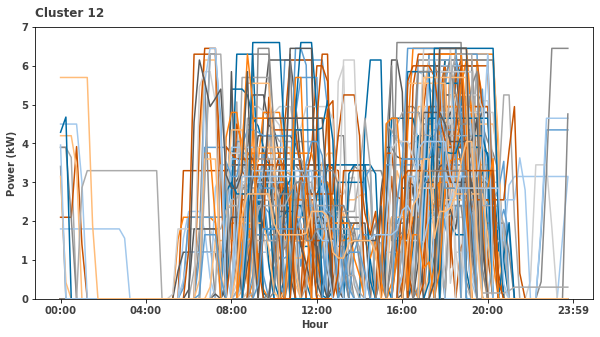

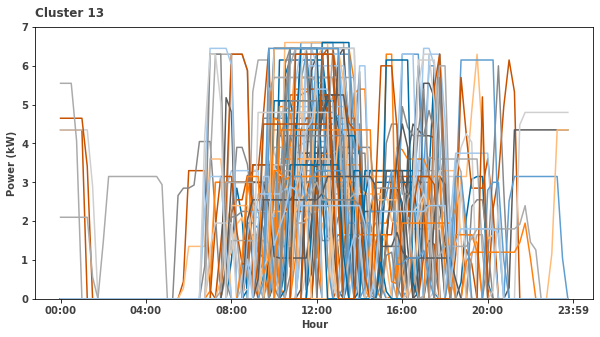

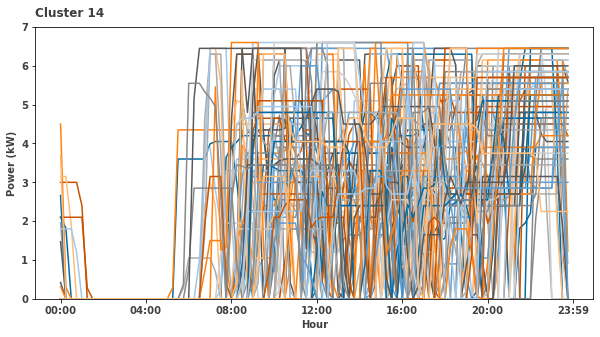

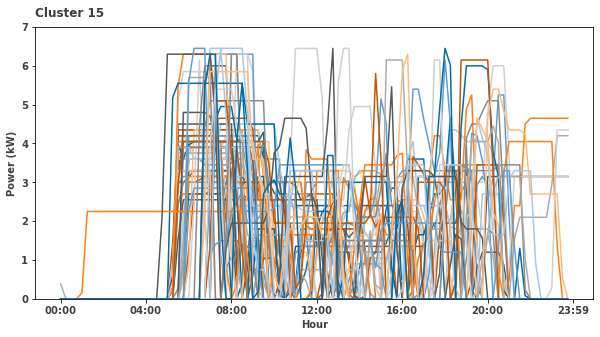

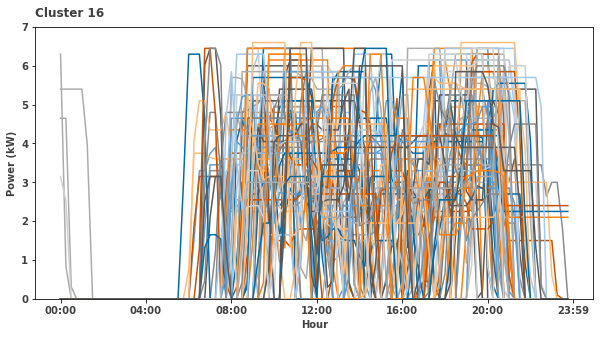

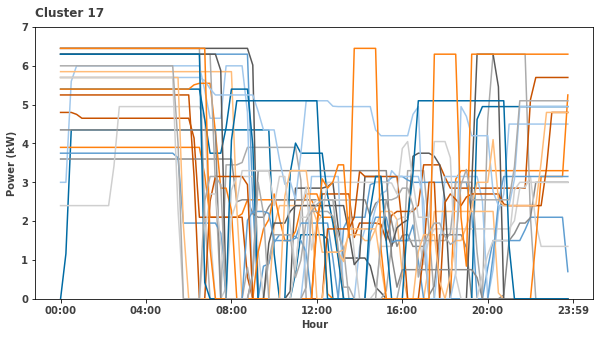

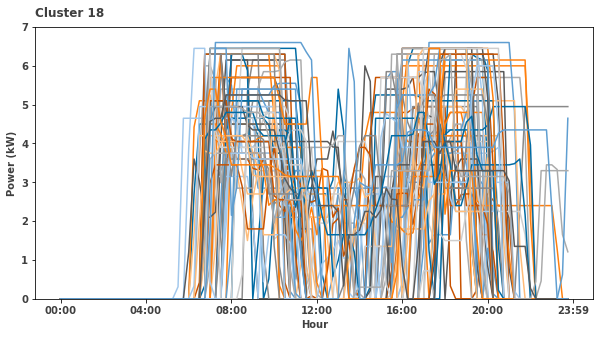

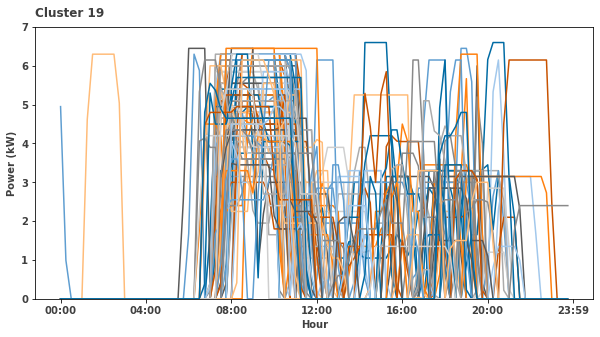

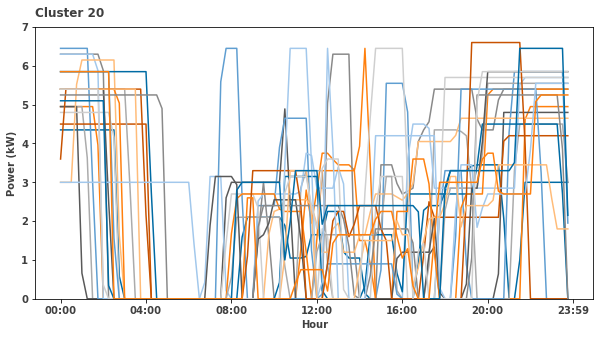

In [32]:
# Number of clusters
clusters = 20

kmeans = KMeans(n_clusters= clusters, random_state= 0)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name= 'Cluster')

# Plot of the median for each cluster
df_pivot2 = df_pivot.copy()
df_pivot2 = df_pivot2.set_index(cluster_found_sr, append= True)

fig, ax= plt.subplots(1,1)
color_list = ["Red", "Green", "Blue", "Yellow", "Orange", "Purple", "Pink", "Brown", "Black", "Cyan", "Magenta",
               "Lime", "Teal", "Indigo", "Maroon", "Navy", "Olive", "Silver", "Gold", "Turquoise"]
cluster_values = sorted(df_pivot2.index.get_level_values('Cluster').unique())
for cluster, color in zip(cluster_values, color_list):
    df_pivot2.xs(cluster, level= 1).T.plot(ax= ax, legend= False, alpha= 0.01, color= color)
    df_pivot2.xs(cluster, level= 1).median().plot(ax= ax, color= color, alpha= 0.9, label= f'Cluster {cluster}')

plt.xlabel("Hour", alpha = 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.xticks(times, alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.ylim(0,7)
plt.title('Daily EV power consumption for ' +str(clusters)+ ' clusters', alpha= 0.75, weight= "bold", loc= "left", pad= 10) 
plt.show()

# Plot of the profiles in each cluster
for cluster_id in sorted(df_pivot2.index.get_level_values(1).unique()):
    df_cluster = df_pivot2.loc[df_pivot2.index.get_level_values(1) == cluster_id].copy()
    df_cluster.T.plot(legend= None)
    plt.xlabel('Hour', alpha= 0.75, weight= "bold")
    plt.ylabel('Power (kW)', alpha= 0.75, weight= "bold")
    plt.xticks(times, alpha= 0.75, weight= "bold")
    plt.yticks(alpha= 0.75, weight= "bold")
    plt.ylim(0,7)
    plt.title(f'Cluster {cluster_id+1}', alpha= 0.75, weight= "bold", loc= "left", pad= 10)
    plt.show()

#### Clusters of Power Consumption

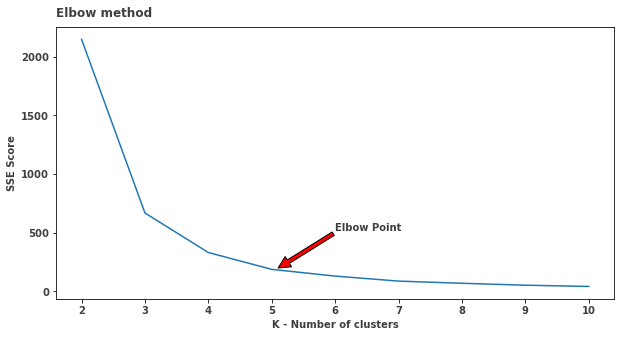

In [23]:
df_clustering = data_final[['Power']]
X = df_clustering.values.copy() 
sc = MinMaxScaler()
X = sc.fit_transform(X)

n_cluster_list = np.arange(2,11).astype(int)

distortions = []

for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters= n_cluster, init= 'k-means++', max_iter= 100, random_state= 0)
    kmeans.fit_predict(X)
    distortions.append(kmeans.inertia_)

plt.plot(n_cluster_list, distortions, color= '#1f77b4')
plt.title('Elbow method', alpha=0.75, weight= "bold", loc= "left", pad= 10) 
plt.annotate('Elbow Point', xy=(5.1, 200), xytext=(6, 520), arrowprops=dict(facecolor='red'), alpha= 0.75, weight= "bold")
plt.xlabel('K - Number of clusters', alpha= 0.75, weight= "bold")
plt.ylabel('SSE Score', alpha= 0.75, weight= "bold")
plt.xticks([2,3,4,5,6,7,8,9,10], alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.show()

In [24]:
# Number of clusters
clusters = 5

kmeans = KMeans(n_clusters= clusters, random_state= 0)
cluster_found = kmeans.fit_predict(X)
data_final['Cluster'] = cluster_found
groups = data_final.groupby('Cluster')['Power'].mean()
groups

Cluster
0    0.011665
1    6.068023
2    3.135677
3    4.508095
4    1.833986
Name: Power, dtype: float64

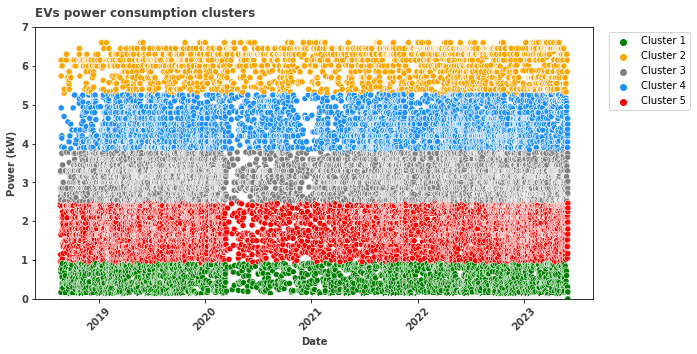

In [25]:
# Plot of power grouped by clusters 
sns.scatterplot(data= data_final, x= data_final.index, y= 'Power', hue= 'Cluster', palette=['green','orange','gray','dodgerblue','red'])
plt.xlabel("Date", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75, weight= "bold", rotation = 45)
plt.yticks(alpha= 0.75, weight= "bold")
handles, labels = plt.gca().get_legend_handles_labels()
legend_labels = dict(zip(handles, ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']))
plt.legend(handles, [legend_labels[h] for h in handles], loc= 'upper left', bbox_to_anchor=(1.02, 1))
plt.title("EVs power consumption clusters", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.ylim(0,7)
plt.show()

### Feature Selection

In [26]:
# Transforming date/time features into two dimensional features
data_final = cyclical_features(data_final)

data_final

Plug  Power  Weekend  Power_lag_1  Power_lag_5  \
Date                                                                  
2018-08-22 08:30:00     1   0.96        0          0.0         0.00   
2018-08-22 08:45:00     1   2.40        0          0.0         0.00   
2018-08-22 09:00:00     1   2.40        0          0.0         0.00   
2018-08-22 09:15:00     1   2.40        0          0.0         0.00   
2018-08-22 09:30:00     1   2.40        0          0.0         0.00   
...                   ...    ...      ...          ...          ...   
2023-06-01 17:00:00     1   1.80        0          0.0         4.57   
2023-06-01 17:15:00     1   2.34        0          3.3         4.65   
2023-06-01 17:30:00     1   0.18        0          4.5         4.65   
2023-06-01 17:45:00     0   0.00        0          4.5         4.65   
2023-06-01 18:00:00     0   0.00        0          4.5         4.35   

                     Power_lag_7  Cluster  Weekofyear_x  Weekofyear_y  \
Date                                                                    
2018-08-22 08:30:00         0.00        4     -0.630088     -0.776524   
2018-08-22 08:45:00         0.00        4     -0.630088     -0.776524   
2018-08-22 09:00:00         0.00        4     -0.630088     -0.776524   
2018-08-22 09:15:00         0.00        4     -0.630088     -0.776524   
2018-08-22 09:30:00         0.00        4     -0.630088     -0.776524   
...                          ...      ...           ...           ...   
2023-06-01 17:00:00         2.25        4     -0.861044      0.508531   
2023-06-01 17:15:00         2.40        4     -0.861044      0.508531   
2023-06-01 17:30:00         2.40        0     -0.861044      0.508531   
2023-06-01 17:45:00         2.40        0     -0.861044      0.508531   
2023-06-01 18:00:00         2.40        0     -0.861044      0.508531   

                     Dayofyear_x  Dayofyear_y      Season_x  Season_y  \
Date                                                                    
2018-08-22 08:30:00    -0.632103    -0.774884 -1.836970e-16      -1.0   
2018-08-22 08:45:00    -0.632103    -0.774884 -1.836970e-16      -1.0   
2018-08-22 09:00:00    -0.632103    -0.774884 -1.836970e-16      -1.0   
2018-08-22 09:15:00    -0.632103    -0.774884 -1.836970e-16      -1.0   
2018-08-22 09:30:00    -0.632103    -0.774884 -1.836970e-16      -1.0   
...                          ...          ...           ...       ...   
2023-06-01 17:00:00    -0.865307     0.501242 -1.836970e-16      -1.0   
2023-06-01 17:15:00    -0.865307     0.501242 -1.836970e-16      -1.0   
2023-06-01 17:30:00    -0.865307     0.501242 -1.836970e-16      -1.0   
2023-06-01 17:45:00    -0.865307     0.501242 -1.836970e-16      -1.0   
2023-06-01 18:00:00    -0.865307     0.501242 -1.836970e-16      -1.0   

                     Month_x       Month_y  Dayofmonth_x  Dayofmonth_y  \
Date                                                                     
2018-08-22 08:30:00     -0.5 -8.660254e-01     -0.250653     -0.968077   
2018-08-22 08:45:00     -0.5 -8.660254e-01     -0.250653     -0.968077   
2018-08-22 09:00:00     -0.5 -8.660254e-01     -0.250653     -0.968077   
2018-08-22 09:15:00     -0.5 -8.660254e-01     -0.250653     -0.968077   
2018-08-22 09:30:00     -0.5 -8.660254e-01     -0.250653     -0.968077   
...                      ...           ...           ...           ...   
2023-06-01 17:00:00     -1.0  1.224647e-16      0.979530      0.201299   
2023-06-01 17:15:00     -1.0  1.224647e-16      0.979530      0.201299   
2023-06-01 17:30:00     -1.0  1.224647e-16      0.979530      0.201299   
2023-06-01 17:45:00     -1.0  1.224647e-16      0.979530      0.201299   
2023-06-01 18:00:00     -1.0  1.224647e-16      0.979530      0.201299   

                     Dayofweek_x  Dayofweek_y        Hour_x    Hour_y  
Date                                                                   
2018-08-22 08:30:00    -0.900969     0.433884 -5.000000e-01  0.866025  
2018-08-22 08:45:0

#### Plug

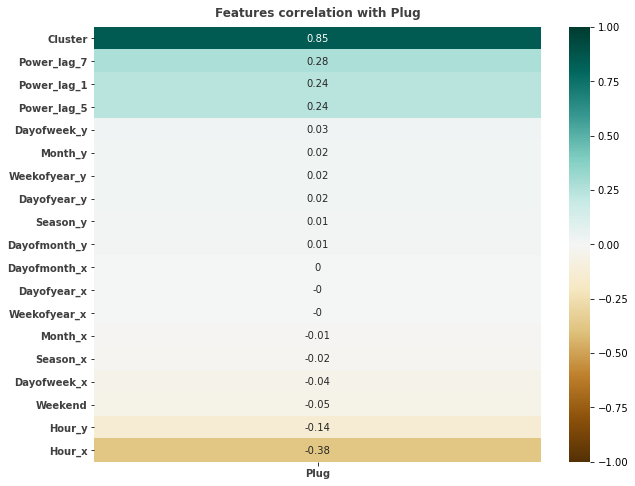

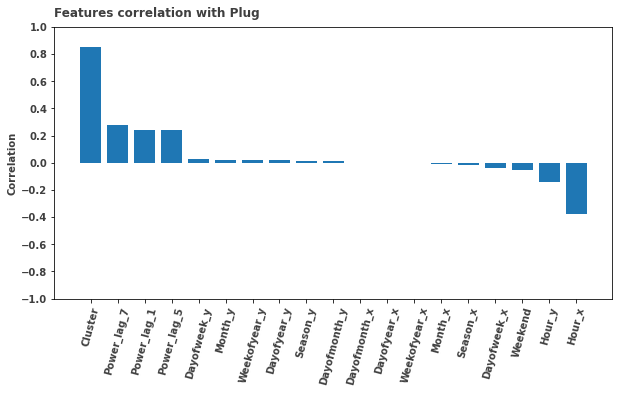

In [27]:
# Correlation matrix
corr = data_final.corr()[['Plug']].sort_values(by= 'Plug', ascending= False).round(2)

# Heatmap features correlation
fig = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(corr[2:], vmin= -1, vmax= 1, annot= True, cmap= 'BrBG')
heatmap.set_title('Features correlation with Plug', alpha= 0.75, weight= "bold", pad= 10)
plt.xticks(alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.show()

# Bar plot of features correlation
plt.bar(corr[2:].index, corr[2:].Plug, color= '#1f77b4')
plt.xticks(rotation= 75, alpha= 0.75, weight= "bold")
plt.yticks(np.arange(-1, 1.1, step= 0.2), alpha=0.75,  weight= "bold")
plt.ylabel('Correlation', alpha= 0.75, weight= "bold")
plt.title("Features correlation with Plug", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

#### Power

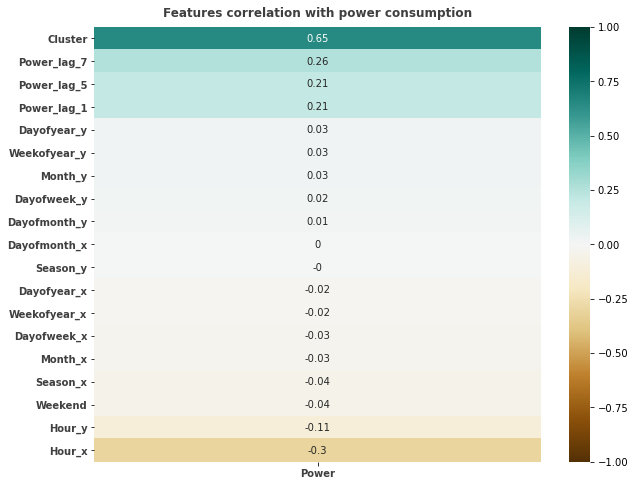

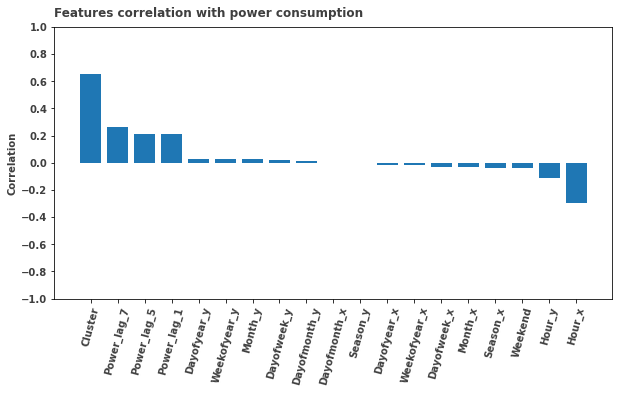

In [28]:
# Correlation matrix
corr = data_final.corr()[['Power']].sort_values(by= 'Power', ascending= False).round(2)

# Heatmap features correlation
fig = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(corr[2:], vmin= -1, vmax= 1, annot= True, cmap= 'BrBG')
heatmap.set_title('Features correlation with power consumption', alpha= 0.75, weight= "bold", pad= 10)
plt.xticks(alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.show()

# Bar plot of features correlation
plt.bar(corr[2:].index, corr[2:].Power, color= '#1f77b4')
plt.xticks(rotation= 75, alpha= 0.75, weight= "bold")
plt.yticks(np.arange(-1, 1.1, step= 0.2), alpha=0.75,  weight= "bold")
plt.ylabel('Correlation', alpha= 0.75, weight= "bold")
plt.title("Features correlation with power consumption", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.show()

In [29]:
# Array containing the names of all features available
all_features = data_final.columns.values.tolist()
all_features.remove('Plug')
all_features.remove('Power')
all_features = np.array(all_features)

# Target variable and features (Y: Power, X: all features)
df_features = data_final.copy().values
Y = df_features[:, 1] 
X = df_features[:, [x for x in range(2, len(all_features)+2)]]

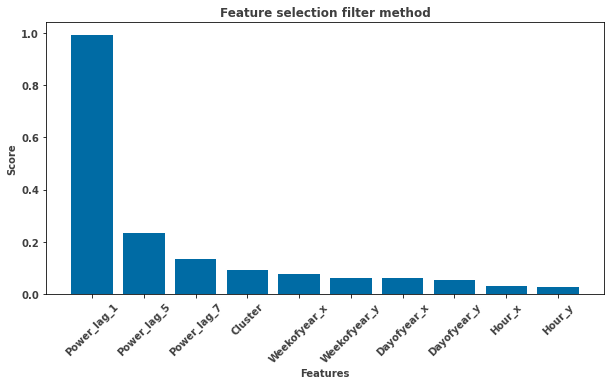

Best 10 features - Filter method (K best)
['Power_lag_1' 'Power_lag_5' 'Power_lag_7' 'Cluster' 'Weekofyear_x'
 'Weekofyear_y' 'Dayofyear_x' 'Dayofyear_y' 'Hour_x' 'Hour_y']
Wall time: 1min 54s


In [55]:
%%time
# Filter method - K best
features1 = SelectKBest(k= 10, score_func= mutual_info_regression)
fit1 = features1.fit(X, Y)
scores = sorted(features1.scores_, reverse=True)
filter1 = all_features[fit1.get_support()]

plt.bar(filter1, scores[:10])
plt.xlabel('Features', alpha= 0.75, weight= "bold")
plt.ylabel('Score', alpha= 0.75, weight= "bold")
plt.xticks(rotation= 45, alpha= 0.75, weight= "bold")
plt.yticks(alpha=0.75,  weight= "bold")
plt.title('Feature selection filter method',alpha= 0.75, weight= "bold")
plt.show()

print('Best 10 features - Filter method (K best)')
print(filter1[:10])

In [41]:
%%time
# Feature importance Random Forest
model2 = RandomForestRegressor()
fit2 = model2.fit(X, Y)
importance2 = pd.DataFrame(data= {'Feature': all_features, 'Score': model2.feature_importances_})
importance2 = importance2.sort_values(by= ['Score'], ascending= False)
importance2.set_index('Feature', inplace= True)

print('Features Score - RF')
print(importance2[:10])

Features Score - RF
                 Score
Feature               
Cluster       0.987024
Dayofyear_y   0.001234
Dayofmonth_y  0.001233
Power_lag_1   0.001212
Power_lag_7   0.001211
Dayofyear_x   0.001208
Power_lag_5   0.001173
Hour_x        0.001065
Hour_y        0.001034
Dayofmonth_x  0.000896
Wall time: 3min


In [42]:
%%time
# Feature importance XGBOOST
model3 = xgb.XGBRegressor()
fit3 = model3.fit(X, Y)
importance3 = pd.DataFrame(data= {'Feature': all_features, 'Score': model3.feature_importances_})
importance3 = importance3.sort_values(by= ['Score'], ascending= False)
importance3.set_index('Feature', inplace= True)

print('Features Score - XGBOOST')
print(importance3[:10])

Features Score - XGBOOST
                 Score
Feature               
Cluster       0.984769
Month_y       0.001974
Month_x       0.000966
Dayofyear_y   0.000962
Weekofyear_x  0.000948
Dayofmonth_y  0.000940
Dayofweek_x   0.000914
Dayofyear_x   0.000908
Hour_y        0.000874
Weekofyear_y  0.000846
Wall time: 9.56 s


In [30]:
%%time
# Feature importance LightGBM
model4 = lgb.LGBMRegressor()
fit4 = model4.fit(X, Y)
importance4 = pd.DataFrame(data= {'Feature': all_features, 'Score': model4.feature_importances_})
importance4 = importance4.sort_values(by= ['Score'], ascending= False)
importance4.set_index('Feature', inplace= True)

print('Features Score - LightGBM')
print(importance4[:10])

Features Score - LightGBM
              Score
Feature            
Dayofyear_x     371
Cluster         344
Dayofyear_y     315
Dayofmonth_y    279
Power_lag_7     216
Power_lag_1     190
Power_lag_5     180
Hour_x          177
Dayofmonth_x    171
Dayofweek_y     160
Wall time: 1.49 s


### Forecasting

#### Daily power consumption profiles for a period (to define the start of the forecast)

Period defined: 2023-05-01 to 2023-05-07


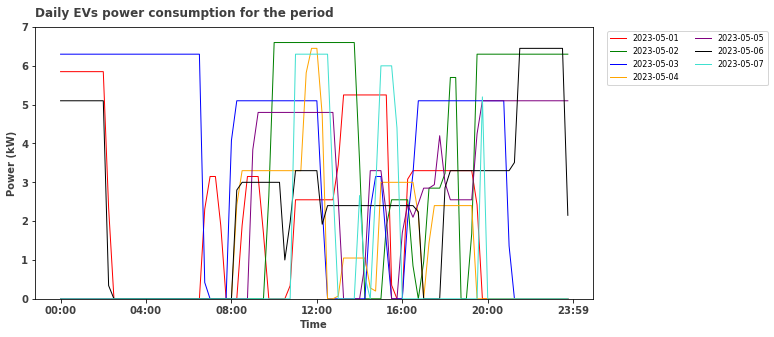

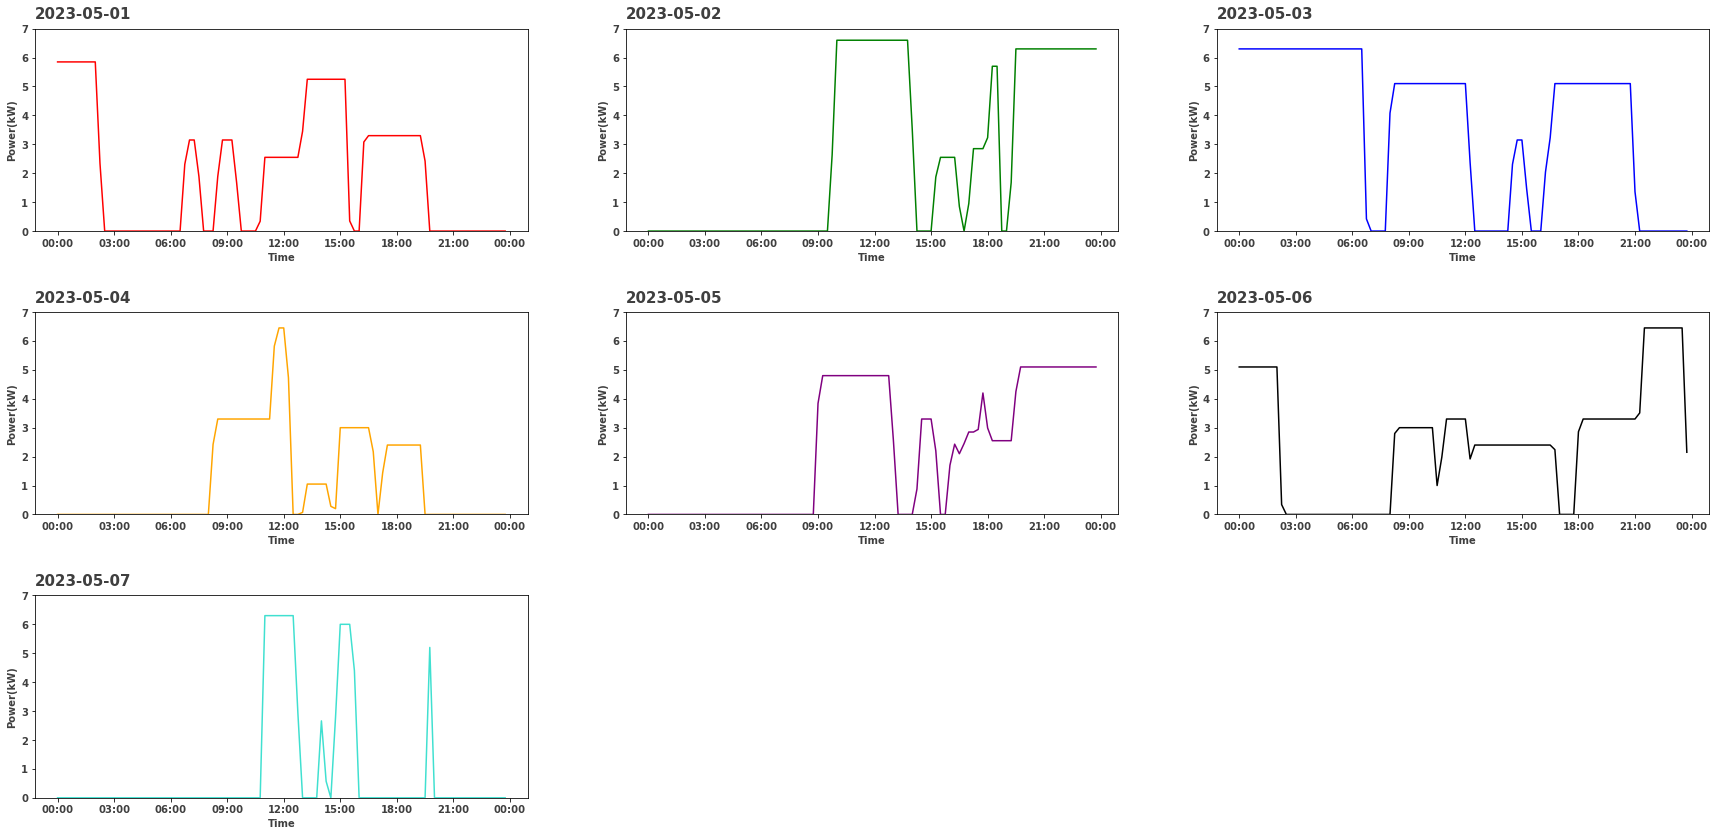

In [51]:
# INPUT the period to analyze (start and end date)
date_start = '2023-05-01'
date_end = '2023-05-07'
print(f'Period defined: {date_start} to {date_end}')
    
data2 = data_final.loc[date_start:date_end, :].copy()
data2['Day'] = data2.index.date
data2['Time'] = data2.index.time
data2 = data2.loc[:, ['Power', 'Day', 'Time']]

# Daily power consumption profiles for the period defined
colors = ["Red", "Green", "Blue", "Orange", "Purple", "Black", "Turquoise"]
data2_pivot = data2.pivot_table(index='Day', values='Power', columns= 'Time')     
data2_pivot.T.plot(linewidth= 1, color=colors)
plt.xlabel("Time", alpha= 0.75, weight= "bold")
plt.ylabel("Power (kW)", alpha= 0.75, weight= "bold")
plt.xticks(times, alpha= 0.75, weight= "bold")
plt.yticks(alpha= 0.75, weight= "bold")
plt.legend(fontsize= 8, loc= 'best', ncol= 2, bbox_to_anchor=(1.32, 1))
plt.title("Daily EVs power consumption for the period", alpha= 0.75, weight= "bold", loc= "left", pad= 10)
plt.ylim(0,7)
plt.show()

# Individual profiles
size = len(data2.Day.unique())
fig = plt.figure(figsize= (30, size*5))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
    
for i, day in enumerate(data2.Day.unique()):
    data_temp = data2[data2.Day == day]
    ax = fig.add_subplot(round(size+1/3), 3, i+1)
    sns.lineplot(data= data_temp, x= 'Date', y= 'Power', color= colors[i])
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xlabel("Time", alpha= 0.75, weight= "bold")
    plt.ylabel("Power(kW)", alpha= 0.75, weight= "bold")
    plt.xticks(alpha= 0.75, weight= "bold")
    plt.yticks(alpha= 0.75, weight= "bold")
    plt.title(day, alpha= 0.75, weight= "bold", loc= "left", pad= 10, fontsize= 15)
    plt.ylim(0,7)
    
plt.show()

#### Inputs

In [31]:
# Define the start date of the forecast
start_forecast = datetime.strptime('2023-05-04', '%Y-%m-%d')

# Define the number of days to forecast
days_to_forecast = 1

# Define forecast variable and features
FORECAST_COLUMN = ['Plug', 'Power']

FEATURE_COLUMNS = ['Cluster','Power_lag_1', 'Power_lag_5', 'Power_lag_7', 'Hour_x', 'Hour_y']

print(f'Forecast variable: {FORECAST_COLUMN}')
print(f'Features: {FEATURE_COLUMNS}')

Forecast variable: ['Plug', 'Power']
Features: ['Cluster', 'Power_lag_1', 'Power_lag_5', 'Power_lag_7', 'Hour_x', 'Hour_y']


In [32]:
# The start of the training is always the beginning of the dataset
start_training = data_final.index[0]

# The end of the training is always 15min before the start of the forecast
end_training = start_forecast - timedelta(minutes= 1)

# The end of the forecast is obtained from the # of days to forecast defined
end_forecast = start_forecast + timedelta(days= days_to_forecast) - timedelta(minutes= 1)

# Print of training and forecast periods
print(f'Data available: {data_final.index[0].date()} to {data_final.index[-1].date()}')
print(f'Days to forecast: {days_to_forecast}')
print(f'Training period: {start_training.date()} to {end_training.date()}')
print(f'Forecast period: {start_forecast.date()} to {end_forecast.date()}')

Data available: 2018-08-22 to 2023-06-01
Days to forecast: 1
Training period: 2018-08-22 to 2023-05-03
Forecast period: 2023-05-04 to 2023-05-04


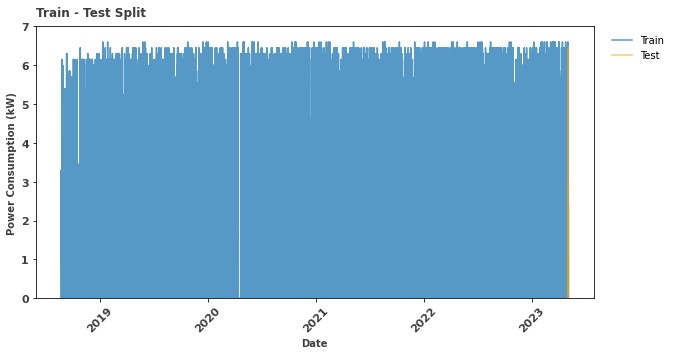

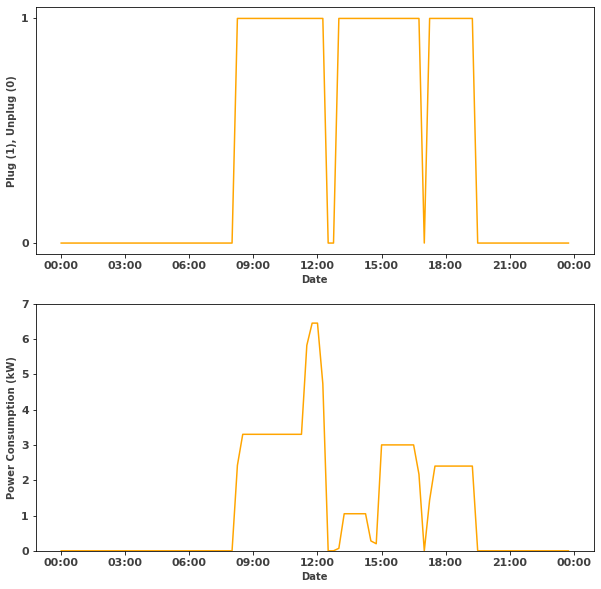

In [94]:
# Using train_test_split
#data_train, data_test = train_test_split(data_final, test_size= 0.2, random_state= 10)

# Dividing into train and test sets
data_train = data_final.loc[start_training : end_training, :].copy()
data_test = data_final.loc[start_forecast : end_forecast, :].copy()

# Plot train-test split
fig, ax = plt.subplots()
plt.plot(data_train.index, data_train["Power"], alpha= 0.75, color= '#1f77b4')
plt.plot(data_test.index, data_test["Power"], alpha= 0.60, color= 'Orange')
plt.xlabel("Date", alpha= 0.75, weight= "bold")
plt.ylabel("Power Consumption (kW)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75,weight= "bold", fontsize= 11, rotation = 45)
plt.yticks(alpha= 0.75,weight= "bold", fontsize= 11)
plt.ylim(0,7)
plt.legend(['Train','Test'], frameon= False, loc= 'upper center', bbox_to_anchor=(1.08, 1))
plt.title("Train - Test Split", alpha=0.75, weight="bold", pad=10, loc="left")
plt.show()

# Plots of Plug and Power for the forecast
fig, ax = plt.subplots(figsize= (10, 10))
plt.subplots_adjust(hspace= 0.2)

plt.subplot(2, 1, 1)
plt.plot(data_test.index, data_test["Plug"], color= 'orange')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Date", alpha= 0.75, weight= "bold")
plt.ylabel("Plug (1), Unplug (0)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75,weight= "bold", fontsize= 11)
plt.yticks([0,1], alpha=0.75,weight="bold", fontsize=11)

plt.subplot(2, 1, 2)
plt.plot(data_test.index, data_test["Power"], color= 'orange')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Date", alpha= 0.75, weight= "bold")
plt.ylabel("Power Consumption (kW)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75,weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75,weight= "bold", fontsize= 11)
plt.ylim(0,7)

plt.show()

### Plug (Classification)

In [39]:
pd.set_option('display.max_rows', None)

In [45]:
%%time
xtrain = data_train.loc[:, FEATURE_COLUMNS]
ytrain = data_train.loc[:, [FORECAST_COLUMN[0]]]

xtest = data_test.loc[:, FEATURE_COLUMNS]
ytest = data_test.loc[:, [FORECAST_COLUMN[0]]]

# XGBOOST
cla_XGBOOST = xgb.XGBClassifier()

cla_XGBOOST.fit(xtrain, ytrain)
    
# Predictions
df_cla = pd.DataFrame(cla_XGBOOST.predict(xtest), columns=['Prediction'], index= xtest.index)
df_cla['Real']= ytest

df_cla

Wall time: 5.23 s


Prediction  Real
Date                                 
2023-05-04 00:00:00           0     0
2023-05-04 00:15:00           0     0
2023-05-04 00:30:00           0     0
2023-05-04 00:45:00           0     0
2023-05-04 01:00:00           0     0
2023-05-04 01:15:00           0     0
2023-05-04 01:30:00           0     0
2023-05-04 01:45:00           0     0
2023-05-04 02:00:00           0     0
2023-05-04 02:15:00           0     0
2023-05-04 02:30:00           0     0
2023-05-04 02:45:00           0     0
2023-05-04 03:00:00           0     0
2023-05-04 03:15:00           0     0
2023-05-04 03:30:00           0     0
2023-05-04 03:45:00           0     0
2023-05-04 04:00:00           0     0
2023-05-04 04:15:00           0     0
2023-05-04 04:30:00           0     0
2023-05-04 04:45:00           0     0
2023-05-04 05:00:00           0     0
2023-05-04 05:15:00           0     0
2023-05-04 05:30:00           0     0
2023-05-04 05:45:00           0     0
2023-05-04 06:00:00           0     0
2023-05-04 06:15:00           0     0
2023-05-04 06:30:00           0     0
2023-05-04 06:45:00           0     0
2023-05-04 07:00:00           0     0
2023-05-04 07:15:00           0     0
2023-05-04 07:30:00           0     0
2023-05-04 07:45:00           0     0
2023-05-04 08:00:00           0     0
2023-05-04 08:15:00           1     1
2023-05-04 08:30:00           1     1
2023-05-04 08:45:00           1     1
2023-05-04 09:00:00           1     1
2023-05-04 09:15:00           1     1
2023-05-04 09:30:00           1     1
2023-05-04 09:45:00           1     1
2023-05-04 10:00:00           1     1
2023-05-04 10:15:00           1     1
2023-05-04 10:30:00           1     1
2023-05-04 10:45:00           1     1
2023-05-04 11:00:00           1     1
2023-05-04 11:15:00           1     1
2023-05-04 11:30:00           1     1
2023-05-04 11:45:00           1     1
2023-05-04 12:00:00           1     1
2023-05-04 12:15:00           1     1
2023-05-04 12:30:00           0     0
2023-05-04 12:45:00           0     0
2023-05-04 13:00:00           0     1
2023-05-04 13:15:00           1     1
2023-05-04 13:30:00           1     1
2023-05-04 13:45:00           1     1
2023-05-04 14:00:00           1     1
2023-05-04 14:15:00           1     1
2023-05-04 14:30:00           0     1
2023-05-04 14:45:00           0     1
2023-05-04 15:00:00           1     1
2023-05-04 15:15:00           1     1
2023-05-04 15:30:00           1     1
2023-05-04 15:45:00           1     1
2023-05-04 16:00:00           1     1
2023-05-04 16:15:00           1     1
2023-05-04 16:30:00           1     1
2023-05-04 16:45:00           1     1
2023-05-04 17:00:00           0     0
2023-05-04 17:15:00           1     1
2023-05-04 17:30:00           1     1
2023-05-04 17:45:00           1     1
2023-05-04 18:00:00           1     1
2023-05-04 18:15:00           1     1
2023-05-04 18:30:00           1     1
2023-05-04 18:45:00           1     1
2023-05-04 19:00:00           1     1
2023-05-04 19:15:00           1     1
2023-05-04 19:30:00           0     0
2023-05-04 19:45:00           0     0
2023-05-04 20:00:00           0     0
2023-05-04 20:15:00           0     0
2023-05-04 20:30:00           0     0
2023-05-04 20:45:00           0     0
2023-05-04 21:00:00           0     0
2023-05-04 21:15:00           0     0
2023-05-04 21:30:00           0     0
2023-05-04 21:45:00           0     0
2023-05-04 22:00:00           0     0
2023-05-04 22:15:00           0     0
2023-05-04 22:30:00           0     0
2023-05-04 22:45:00           0     0
2023-05-04 23:00:00           0     0
2023-05-04 23:15:00           0     0
2023-05-04 23:30:00           0     0
2023-05-04 23:45:00           0     0

XGBOOST Classifier Accuracy for Plug: 0.97
Confusion matrix, without normalization
[[39  3]
 [ 0 54]]


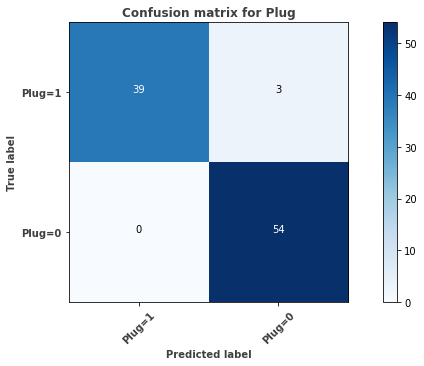

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       1.00      0.93      0.96        42

    accuracy                           0.97        96
   macro avg       0.97      0.96      0.97        96
weighted avg       0.97      0.97      0.97        96



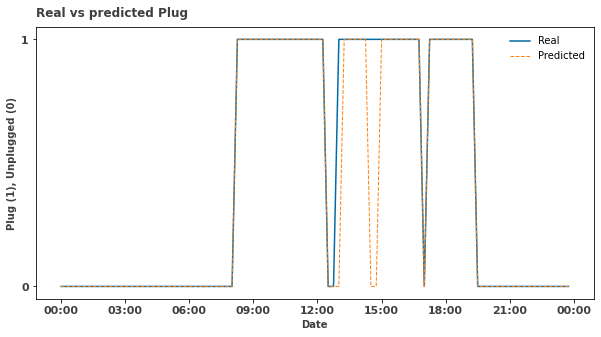

In [53]:
# Accuracy
accuracy = accuracy_score(df_cla.Real, df_cla.Prediction)
print(f'XGBOOST Classifier Accuracy for Plug: {accuracy:.2f}')

# Confusion matrix
cnf_matrix = confusion_matrix(df_cla.Real, df_cla.Prediction, labels= [1,0])
np.set_printoptions(precision= 2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['Plug=1','Plug=0'], normalize= False, title= 'Confusion matrix for Plug')
plt.show()

print(classification_report(df_cla.Real, df_cla.Prediction))

# Real vs predictions in the same plot
fig,ax = plt.subplots()
ax.plot(df_cla.Real, label="Real")
ax.plot(df_cla.Prediction, label="Predicted", ls='--', linewidth = 1)
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel('Plug (1), Unplugged (0)', alpha=0.75, weight="bold")
plt.xticks(alpha=0.75,weight="bold",fontsize=11)
plt.yticks([0,1], alpha=0.75,weight="bold", fontsize=11)
plt.legend(frameon=False, loc='best')
plt.title("Real vs predicted Plug", alpha=0.75, weight="bold", pad=10, loc="left")
plt.show()

### Power (Regression)

In [59]:
xtrain = data_train.loc[:, FEATURE_COLUMNS]
ytrain = data_train.loc[:, [FORECAST_COLUMN[1]]]

xtest = data_test.loc[:, FEATURE_COLUMNS]
ytest = data_test.loc[:, [FORECAST_COLUMN[1]]]

#### Persistence

In [60]:
%%time
# Persistence forecast, values of the last day
df_persistence = data_final.loc[start_forecast : end_forecast, ['Power_lag_1', 'Power']].copy()
df_persistence.rename(columns= {'Power_lag_1': 'Prediction', 'Power':'Real'}, inplace= True)
df_persistence

Wall time: 4.55 ms


Prediction  Real
Date                                 
2023-05-04 00:00:00        6.30  0.00
2023-05-04 00:15:00        6.30  0.00
2023-05-04 00:30:00        6.30  0.00
2023-05-04 00:45:00        6.30  0.00
2023-05-04 01:00:00        6.30  0.00
2023-05-04 01:15:00        6.30  0.00
2023-05-04 01:30:00        6.30  0.00
2023-05-04 01:45:00        6.30  0.00
2023-05-04 02:00:00        6.30  0.00
2023-05-04 02:15:00        6.30  0.00
2023-05-04 02:30:00        6.30  0.00
2023-05-04 02:45:00        6.30  0.00
2023-05-04 03:00:00        6.30  0.00
2023-05-04 03:15:00        6.30  0.00
2023-05-04 03:30:00        6.30  0.00
2023-05-04 03:45:00        6.30  0.00
2023-05-04 04:00:00        6.30  0.00
2023-05-04 04:15:00        6.30  0.00
2023-05-04 04:30:00        6.30  0.00
2023-05-04 04:45:00        6.30  0.00
2023-05-04 05:00:00        6.30  0.00
2023-05-04 05:15:00        6.30  0.00
2023-05-04 05:30:00        6.30  0.00
2023-05-04 05:45:00        6.30  0.00
2023-05-04 06:00:00        6.30  0.00
2023-05-04 06:15:00        6.30  0.00
2023-05-04 06:30:00        6.30  0.00
2023-05-04 06:45:00        0.42  0.00
2023-05-04 07:00:00        0.00  0.00
2023-05-04 07:15:00        0.00  0.00
2023-05-04 07:30:00        0.00  0.00
2023-05-04 07:45:00        0.00  0.00
2023-05-04 08:00:00        4.08  0.00
2023-05-04 08:15:00        5.10  2.42
2023-05-04 08:30:00        5.10  3.30
2023-05-04 08:45:00        5.10  3.30
2023-05-04 09:00:00        5.10  3.30
2023-05-04 09:15:00        5.10  3.30
2023-05-04 09:30:00        5.10  3.30
2023-05-04 09:45:00        5.10  3.30
2023-05-04 10:00:00        5.10  3.30
2023-05-04 10:15:00        5.10  3.30
2023-05-04 10:30:00        5.10  3.30
2023-05-04 10:45:00        5.10  3.30
2023-05-04 11:00:00        5.10  3.30
2023-05-04 11:15:00        5.10  3.30
2023-05-04 11:30:00        5.10  5.82
2023-05-04 11:45:00        5.10  6.45
2023-05-04 12:00:00        5.10  6.45
2023-05-04 12:15:00        2.38  4.73
2023-05-04 12:30:00        0.00  0.00
2023-05-04 12:45:00        0.00  0.00
2023-05-04 13:00:00        0.00  0.07
2023-05-04 13:15:00        0.00  1.05
2023-05-04 13:30:00        0.00  1.05
2023-05-04 13:45:00        0.00  1.05
2023-05-04 14:00:00        0.00  1.05
2023-05-04 14:15:00        0.00  1.05
2023-05-04 14:30:00        2.31  0.28
2023-05-04 14:45:00        3.15  0.20
2023-05-04 15:00:00        3.15  3.00
2023-05-04 15:15:00        1.47  3.00
2023-05-04 15:30:00        0.00  3.00
2023-05-04 15:45:00        0.00  3.00
2023-05-04 16:00:00        0.00  3.00
2023-05-04 16:15:00        2.04  3.00
2023-05-04 16:30:00        3.23  3.00
2023-05-04 16:45:00        5.10  2.17
2023-05-04 17:00:00        5.10  0.00
2023-05-04 17:15:00        5.10  1.44
2023-05-04 17:30:00        5.10  2.40
2023-05-04 17:45:00        5.10  2.40
2023-05-04 18:00:00        5.10  2.40
2023-05-04 18:15:00        5.10  2.40
2023-05-04 18:30:00        5.10  2.40
2023-05-04 18:45:00        5.10  2.40
2023-05-04 19:00:00        5.10  2.40
2023-05-04 19:15:00        5.10  2.40
2023-05-04 19:30:00        5.10  0.00
2023-05-04 19:45:00        5.10  0.00
2023-05-04 20:00:00        5.10  0.00
2023-05-04 20:15:00        5.10  0.00
2023-05-04 20:30:00        5.10  0.00
2023-05-04 20:45:00        5.10  0.00
2023-05-04 21:00:00        1.36  0.00
2023-05-04 21:15:00        0.00  0.00
2023-05-04 21:30:00        0.00  0.00
2023-05-04 21:45:00        0.00  0.00
2023-05-04 22:00:00        0.00  0.00
2023-05-04 22:15:00        0.00  0.00
2023-05-04 22:30:00        0.00  0.00
2023-05-04 22:45:00        0.00  0.00
2023-05-04 23:00:00        0.00  0.00
2023-05-04 23:15:00        0.00  0.00
2023-05-04 23:30:00        0.00  0.00
2023-05-04 23:45:00        0.00  0.00

In [61]:
# Errors
MAE_per, RMSE_per, normRMSE_per, R2_per = compute_errors(df_persistence, ytest.Power.max())

print(f'Persistence - Mean Absolute Error (MAE): {MAE_per:.2f} kW')
print(f'Persistence - Root Mean Square Error (RMSE): {RMSE_per:.2f} kW')
print(f'Persistence - Normalized RMSE: {normRMSE_per:.2f} %')
print(f'Persistence - R square: {R2_per:.2f}')

Persistence - Mean Absolute Error (MAE): 3.04 kW
Persistence - Root Mean Square Error (RMSE): 3.90 kW
Persistence - Normalized RMSE: 60.40 %
Persistence - R square: -4.61


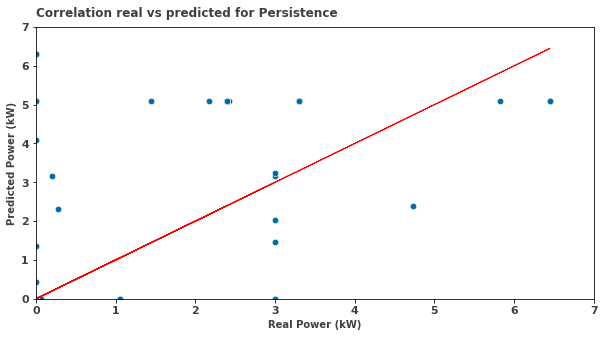

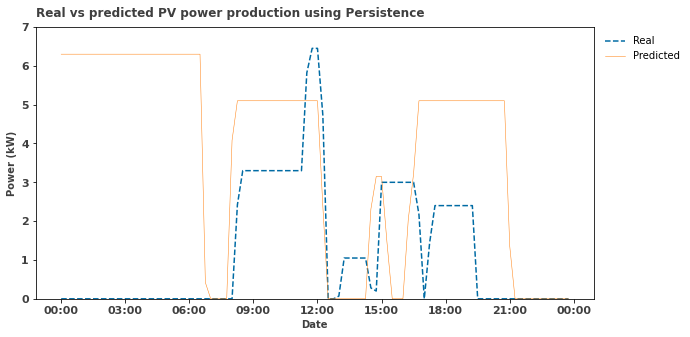

In [64]:
# Plots real vs predicted
result_plots(df_persistence, 'Persistence')

#### Multiple Linear Regression (MLR)

In [65]:
%%time
# Model
reg_LR = LinearRegression()
reg_LR.fit(xtrain, ytrain)

# Predictions and pos-processing
df_LR = pd.DataFrame(reg_LR.predict(xtest), columns= ['Prediction'], index= xtest.index)
df_LR['Real'] = ytest
df_LR['Prediction'] = np.where((df_LR['Prediction'] < 0.3 * max(df_LR['Prediction'])) | (df_LR['Prediction'] < 0), 0, df_LR['Prediction'])

Wall time: 291 ms


In [66]:
# Forecasts obatined for LR
df_LR

Prediction  Real
Date                                 
2023-05-04 00:00:00    0.000000  0.00
2023-05-04 00:15:00    0.000000  0.00
2023-05-04 00:30:00    0.000000  0.00
2023-05-04 00:45:00    0.000000  0.00
2023-05-04 01:00:00    0.000000  0.00
2023-05-04 01:15:00    0.000000  0.00
2023-05-04 01:30:00    0.000000  0.00
2023-05-04 01:45:00    0.000000  0.00
2023-05-04 02:00:00    0.000000  0.00
2023-05-04 02:15:00    0.000000  0.00
2023-05-04 02:30:00    0.000000  0.00
2023-05-04 02:45:00    0.000000  0.00
2023-05-04 03:00:00    0.000000  0.00
2023-05-04 03:15:00    0.000000  0.00
2023-05-04 03:30:00    0.000000  0.00
2023-05-04 03:45:00    0.000000  0.00
2023-05-04 04:00:00    0.000000  0.00
2023-05-04 04:15:00    0.000000  0.00
2023-05-04 04:30:00    0.000000  0.00
2023-05-04 04:45:00    0.000000  0.00
2023-05-04 05:00:00    0.000000  0.00
2023-05-04 05:15:00    0.000000  0.00
2023-05-04 05:30:00    0.000000  0.00
2023-05-04 05:45:00    0.000000  0.00
2023-05-04 06:00:00    0.000000  0.00
2023-05-04 06:15:00    0.000000  0.00
2023-05-04 06:30:00    0.000000  0.00
2023-05-04 06:45:00    0.000000  0.00
2023-05-04 07:00:00    0.000000  0.00
2023-05-04 07:15:00    0.000000  0.00
2023-05-04 07:30:00    0.000000  0.00
2023-05-04 07:45:00    0.000000  0.00
2023-05-04 08:00:00    0.000000  0.00
2023-05-04 08:15:00    4.340989  2.42
2023-05-04 08:30:00    2.592032  3.30
2023-05-04 08:45:00    2.592032  3.30
2023-05-04 09:00:00    2.604680  3.30
2023-05-04 09:15:00    2.391094  3.30
2023-05-04 09:30:00    2.391094  3.30
2023-05-04 09:45:00    2.391094  3.30
2023-05-04 10:00:00    2.432907  3.30
2023-05-04 10:15:00    2.432907  3.30
2023-05-04 10:30:00    2.432907  3.30
2023-05-04 10:45:00    2.432907  3.30
2023-05-04 11:00:00    2.468176  3.30
2023-05-04 11:15:00    2.468176  3.30
2023-05-04 11:30:00    1.566996  5.82
2023-05-04 11:45:00    1.566996  6.45
2023-05-04 12:00:00    1.593318  6.45
2023-05-04 12:15:00    3.304464  4.73
2023-05-04 12:30:00    0.000000  0.00
2023-05-04 12:45:00    0.000000  0.00
2023-05-04 13:00:00    0.000000  0.07
2023-05-04 13:15:00    4.549747  1.05
2023-05-04 13:30:00    4.549747  1.05
2023-05-04 13:45:00    4.549747  1.05
2023-05-04 14:00:00    4.553524  1.05
2023-05-04 14:15:00    4.553524  1.05
2023-05-04 14:30:00    0.000000  0.28
2023-05-04 14:45:00    0.000000  0.20
2023-05-04 15:00:00    2.938548  3.00
2023-05-04 15:15:00    2.904720  3.00
2023-05-04 15:30:00    2.855425  3.00
2023-05-04 15:45:00    2.733375  3.00
2023-05-04 16:00:00    2.542257  3.00
2023-05-04 16:15:00    2.610667  3.00
2023-05-04 16:30:00    2.650573  3.00
2023-05-04 16:45:00    4.515641  2.17
2023-05-04 17:00:00    0.000000  0.00
2023-05-04 17:15:00    4.532656  1.44
2023-05-04 17:30:00    4.532656  2.40
2023-05-04 17:45:00    4.532656  2.40
2023-05-04 18:00:00    4.413253  2.40
2023-05-04 18:15:00    4.414818  2.40
2023-05-04 18:30:00    4.567383  2.40
2023-05-04 18:45:00    4.555106  2.40
2023-05-04 19:00:00    4.530330  2.40
2023-05-04 19:15:00    4.535024  2.40
2023-05-04 19:30:00    0.000000  0.00
2023-05-04 19:45:00    0.000000  0.00
2023-05-04 20:00:00    0.000000  0.00
2023-05-04 20:15:00    0.000000  0.00
2023-05-04 20:30:00    0.000000  0.00
2023-05-04 20:45:00    0.000000  0.00
2023-05-04 21:00:00    0.000000  0.00
2023-05-04 21:15:00    0.000000  0.00
2023-05-04 21:30:00    0.000000  0.00
2023-05-04 21:45:00    0.000000  0.00
2023-05-04 22:00:00    0.000000  0.00
2023-05-04 22:15:00    0.000000  0.00
2023-05-04 22:30:00    0.000000  0.00
2023-05-04 22:45:00    0.000000  0.00
2023-05-04 23:00:00    0.000000  0.00
2023-05-04 23:15:00    0.000000  0.00
2023-05-04 23:30:00    0.000000  0.00
2023-05-04 23:45:00    0.000000  0.00

In [67]:
# Errors
MAE_LR, RMSE_LR, normRMSE_LR, R2_LR = compute_errors(df_LR, ytest.Power.max())

print(f'MLR - Mean Absolute Error (MAE): {MAE_LR:.2f} kW')
print(f'MLR - Root Mean Square Error (RMSE): {RMSE_LR:.2f} kW')
print(f'MLR - Normalized RMSE: {normRMSE_LR:.2f} %')
print(f'MLR - R square: {R2_LR:.2f}')

MLR - Mean Absolute Error (MAE): 0.72 kW
MLR - Root Mean Square Error (RMSE): 1.42 kW
MLR - Normalized RMSE: 21.94 %
MLR - R square: 0.26


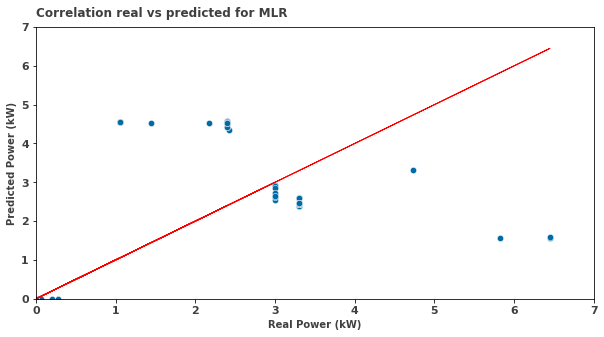

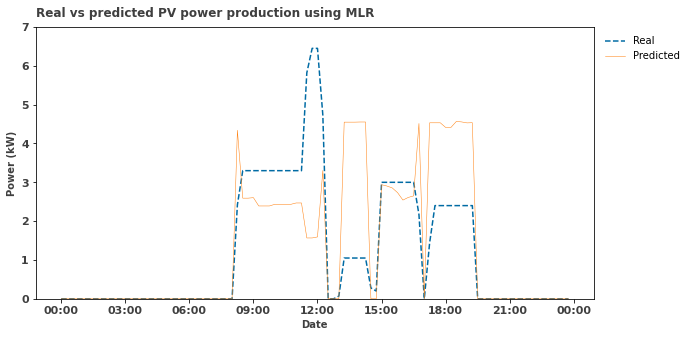

In [68]:
# Plots real vs predicted
result_plots(df_LR, 'MLR')

#### Decision Trees (DT)

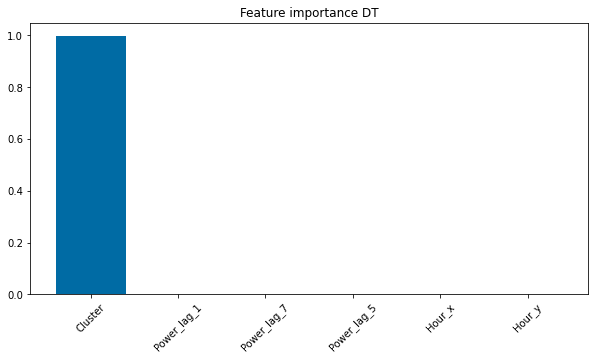

Wall time: 698 ms


In [69]:
%%time
# Model
reg_DT = DecisionTreeRegressor(random_state= 18, max_depth= 10)
reg_DT.fit(xtrain, np.ravel(ytrain))

# Feature importance
importances = reg_DT.feature_importances_
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:len(FEATURE_COLUMNS)]
x = range(len(sorted_index_top))

labels = np.array(FEATURE_COLUMNS)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label= labels)
plt.title("Feature importance DT")
plt.xticks(rotation= 45)
plt.show()

#Predictions and pos-processing
df_DT = pd.DataFrame(reg_DT.predict(xtest), columns= ['Prediction'], index= xtest.index)
df_DT['Real'] = ytest
df_DT['Prediction'] = np.where((df_DT['Prediction'] < 0.15 * max(df_DT['Prediction'])) | (df_DT['Prediction'] < 0), 0, df_DT['Prediction'])

In [70]:
# Forecasts obatined for DT
df_DT

Prediction  Real
Date                                 
2023-05-04 00:00:00    0.000000  0.00
2023-05-04 00:15:00    0.000000  0.00
2023-05-04 00:30:00    0.000000  0.00
2023-05-04 00:45:00    0.000000  0.00
2023-05-04 01:00:00    0.000000  0.00
2023-05-04 01:15:00    0.000000  0.00
2023-05-04 01:30:00    0.000000  0.00
2023-05-04 01:45:00    0.000000  0.00
2023-05-04 02:00:00    0.000000  0.00
2023-05-04 02:15:00    0.000000  0.00
2023-05-04 02:30:00    0.000000  0.00
2023-05-04 02:45:00    0.000000  0.00
2023-05-04 03:00:00    0.000000  0.00
2023-05-04 03:15:00    0.000000  0.00
2023-05-04 03:30:00    0.000000  0.00
2023-05-04 03:45:00    0.000000  0.00
2023-05-04 04:00:00    0.000000  0.00
2023-05-04 04:15:00    0.000000  0.00
2023-05-04 04:30:00    0.000000  0.00
2023-05-04 04:45:00    0.000000  0.00
2023-05-04 05:00:00    0.000000  0.00
2023-05-04 05:15:00    0.000000  0.00
2023-05-04 05:30:00    0.000000  0.00
2023-05-04 05:45:00    0.000000  0.00
2023-05-04 06:00:00    0.000000  0.00
2023-05-04 06:15:00    0.000000  0.00
2023-05-04 06:30:00    0.000000  0.00
2023-05-04 06:45:00    0.000000  0.00
2023-05-04 07:00:00    0.000000  0.00
2023-05-04 07:15:00    0.000000  0.00
2023-05-04 07:30:00    0.000000  0.00
2023-05-04 07:45:00    0.000000  0.00
2023-05-04 08:00:00    0.000000  0.00
2023-05-04 08:15:00    1.860806  2.42
2023-05-04 08:30:00    3.234545  3.30
2023-05-04 08:45:00    3.234545  3.30
2023-05-04 09:00:00    3.511343  3.30
2023-05-04 09:15:00    3.135768  3.30
2023-05-04 09:30:00    3.135768  3.30
2023-05-04 09:45:00    3.135768  3.30
2023-05-04 10:00:00    3.135768  3.30
2023-05-04 10:15:00    3.135768  3.30
2023-05-04 10:30:00    3.135768  3.30
2023-05-04 10:45:00    3.135768  3.30
2023-05-04 11:00:00    3.135768  3.30
2023-05-04 11:15:00    3.135768  3.30
2023-05-04 11:30:00    6.047388  5.82
2023-05-04 11:45:00    6.047388  6.45
2023-05-04 12:00:00    6.047388  6.45
2023-05-04 12:15:00    4.499395  4.73
2023-05-04 12:30:00    0.000000  0.00
2023-05-04 12:45:00    0.000000  0.00
2023-05-04 13:00:00    0.000000  0.07
2023-05-04 13:15:00    2.056000  1.05
2023-05-04 13:30:00    2.056000  1.05
2023-05-04 13:45:00    2.056000  1.05
2023-05-04 14:00:00    2.056000  1.05
2023-05-04 14:15:00    2.056000  1.05
2023-05-04 14:30:00    0.000000  0.28
2023-05-04 14:45:00    0.000000  0.20
2023-05-04 15:00:00    3.049891  3.00
2023-05-04 15:15:00    3.187617  3.00
2023-05-04 15:30:00    3.187617  3.00
2023-05-04 15:45:00    3.187617  3.00
2023-05-04 16:00:00    3.187617  3.00
2023-05-04 16:15:00    3.049891  3.00
2023-05-04 16:30:00    3.049891  3.00
2023-05-04 16:45:00    1.833277  2.17
2023-05-04 17:00:00    0.000000  0.00
2023-05-04 17:15:00    1.754839  1.44
2023-05-04 17:30:00    1.754839  2.40
2023-05-04 17:45:00    1.754839  2.40
2023-05-04 18:00:00    1.777143  2.40
2023-05-04 18:15:00    1.777143  2.40
2023-05-04 18:30:00    1.894348  2.40
2023-05-04 18:45:00    1.894348  2.40
2023-05-04 19:00:00    1.894348  2.40
2023-05-04 19:15:00    1.894348  2.40
2023-05-04 19:30:00    0.000000  0.00
2023-05-04 19:45:00    0.000000  0.00
2023-05-04 20:00:00    0.000000  0.00
2023-05-04 20:15:00    0.000000  0.00
2023-05-04 20:30:00    0.000000  0.00
2023-05-04 20:45:00    0.000000  0.00
2023-05-04 21:00:00    0.000000  0.00
2023-05-04 21:15:00    0.000000  0.00
2023-05-04 21:30:00    0.000000  0.00
2023-05-04 21:45:00    0.000000  0.00
2023-05-04 22:00:00    0.000000  0.00
2023-05-04 22:15:00    0.000000  0.00
2023-05-04 22:30:00    0.000000  0.00
2023-05-04 22:45:00    0.000000  0.00
2023-05-04 23:00:00    0.000000  0.00
2023-05-04 23:15:00    0.000000  0.00
2023-05-04 23:30:00    0.000000  0.00
2023-05-04 23:45:00    0.000000  0.00

In [71]:
# Errors
MAE_DT, RMSE_DT, normRMSE_DT, R2_DT = compute_errors(df_DT, ytest.Power.max())

print(f'DT - Mean Absolute Error (MAE): {MAE_DT:.2f} kW')
print(f'DT - Root Mean Square Error (RMSE): {RMSE_DT:.2f} kW')
print(f'DT - Normalized RMSE: {normRMSE_DT:.2f} %')
print(f'DT - R square: {R2_DT:.2f}')

DT - Mean Absolute Error (MAE): 0.16 kW
DT - Root Mean Square Error (RMSE): 0.31 kW
DT - Normalized RMSE: 4.80 %
DT - R square: 0.96


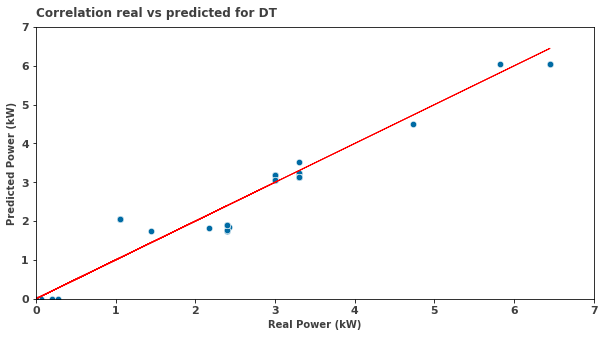

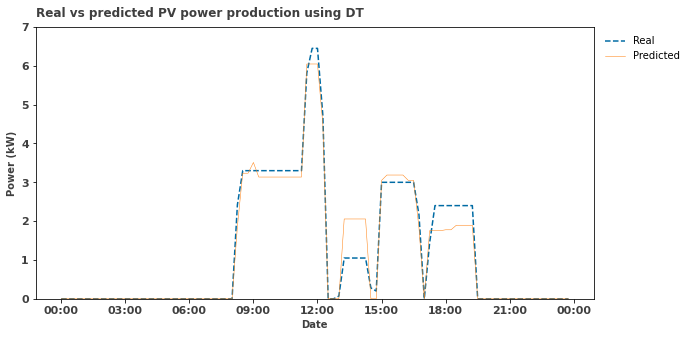

In [72]:
# Plots real vs predicted
result_plots(df_DT, 'DT')

#### Random Forest (RF)

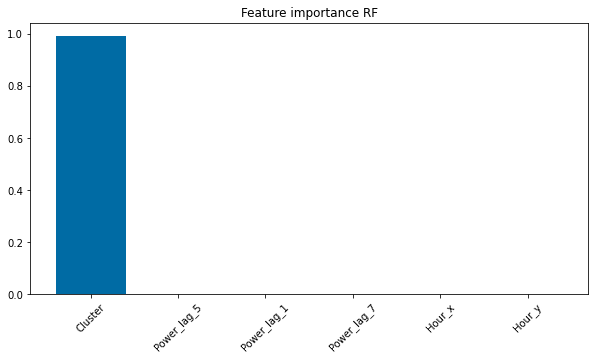

Wall time: 3min 26s


In [73]:
%%time
# Model
parameters_RF = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 500, 
              'min_samples_split': 7,
              'max_depth': 30,
              'max_leaf_nodes': None,
              'random_state': 18}

reg_RF = RandomForestRegressor(**parameters_RF)
reg_RF.fit(xtrain, np.ravel(ytrain))

# Feature importance
importances = reg_RF.feature_importances_
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:len(FEATURE_COLUMNS)]
x = range(len(sorted_index_top))

labels = np.array(FEATURE_COLUMNS)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label= labels)
plt.title("Feature importance RF")
plt.xticks(rotation= 45)
plt.show()

# Predictions and pos-processing
df_RF = pd.DataFrame(reg_RF.predict(xtest), columns=['Prediction'], index= xtest.index)
df_RF['Real'] = ytest
df_RF['Prediction'] = np.where((df_RF['Prediction'] < 0.15 * max(df_RF['Prediction'])) | (df_RF['Prediction'] < 0), 0, df_RF['Prediction'])

In [74]:
# Forecasts obatined for RF
df_RF

Prediction  Real
Date                                 
2023-05-04 00:00:00    0.000000  0.00
2023-05-04 00:15:00    0.000000  0.00
2023-05-04 00:30:00    0.000000  0.00
2023-05-04 00:45:00    0.000000  0.00
2023-05-04 01:00:00    0.000000  0.00
2023-05-04 01:15:00    0.000000  0.00
2023-05-04 01:30:00    0.000000  0.00
2023-05-04 01:45:00    0.000000  0.00
2023-05-04 02:00:00    0.000000  0.00
2023-05-04 02:15:00    0.000000  0.00
2023-05-04 02:30:00    0.000000  0.00
2023-05-04 02:45:00    0.000000  0.00
2023-05-04 03:00:00    0.000000  0.00
2023-05-04 03:15:00    0.000000  0.00
2023-05-04 03:30:00    0.000000  0.00
2023-05-04 03:45:00    0.000000  0.00
2023-05-04 04:00:00    0.000000  0.00
2023-05-04 04:15:00    0.000000  0.00
2023-05-04 04:30:00    0.000000  0.00
2023-05-04 04:45:00    0.000000  0.00
2023-05-04 05:00:00    0.000000  0.00
2023-05-04 05:15:00    0.000000  0.00
2023-05-04 05:30:00    0.000000  0.00
2023-05-04 05:45:00    0.000000  0.00
2023-05-04 06:00:00    0.000000  0.00
2023-05-04 06:15:00    0.000000  0.00
2023-05-04 06:30:00    0.000000  0.00
2023-05-04 06:45:00    0.000000  0.00
2023-05-04 07:00:00    0.000000  0.00
2023-05-04 07:15:00    0.000000  0.00
2023-05-04 07:30:00    0.000000  0.00
2023-05-04 07:45:00    0.000000  0.00
2023-05-04 08:00:00    0.000000  0.00
2023-05-04 08:15:00    1.943896  2.42
2023-05-04 08:30:00    3.251699  3.30
2023-05-04 08:45:00    3.251699  3.30
2023-05-04 09:00:00    3.186482  3.30
2023-05-04 09:15:00    3.068791  3.30
2023-05-04 09:30:00    3.068791  3.30
2023-05-04 09:45:00    3.068791  3.30
2023-05-04 10:00:00    3.144250  3.30
2023-05-04 10:15:00    3.144250  3.30
2023-05-04 10:30:00    3.144250  3.30
2023-05-04 10:45:00    3.144250  3.30
2023-05-04 11:00:00    3.135217  3.30
2023-05-04 11:15:00    3.135217  3.30
2023-05-04 11:30:00    6.244273  5.82
2023-05-04 11:45:00    6.244273  6.45
2023-05-04 12:00:00    6.272621  6.45
2023-05-04 12:15:00    4.682802  4.73
2023-05-04 12:30:00    0.000000  0.00
2023-05-04 12:45:00    0.000000  0.00
2023-05-04 13:00:00    0.000000  0.07
2023-05-04 13:15:00    2.083412  1.05
2023-05-04 13:30:00    2.083412  1.05
2023-05-04 13:45:00    2.083412  1.05
2023-05-04 14:00:00    2.148357  1.05
2023-05-04 14:15:00    2.148357  1.05
2023-05-04 14:30:00    0.000000  0.28
2023-05-04 14:45:00    0.000000  0.20
2023-05-04 15:00:00    3.127110  3.00
2023-05-04 15:15:00    3.021753  3.00
2023-05-04 15:30:00    3.023859  3.00
2023-05-04 15:45:00    3.136923  3.00
2023-05-04 16:00:00    3.272076  3.00
2023-05-04 16:15:00    3.190087  3.00
2023-05-04 16:30:00    3.089223  3.00
2023-05-04 16:45:00    1.766833  2.17
2023-05-04 17:00:00    0.000000  0.00
2023-05-04 17:15:00    1.688959  1.44
2023-05-04 17:30:00    1.688959  2.40
2023-05-04 17:45:00    1.688959  2.40
2023-05-04 18:00:00    1.716979  2.40
2023-05-04 18:15:00    1.723294  2.40
2023-05-04 18:30:00    1.892427  2.40
2023-05-04 18:45:00    1.866361  2.40
2023-05-04 19:00:00    1.792706  2.40
2023-05-04 19:15:00    1.817110  2.40
2023-05-04 19:30:00    0.000000  0.00
2023-05-04 19:45:00    0.000000  0.00
2023-05-04 20:00:00    0.000000  0.00
2023-05-04 20:15:00    0.000000  0.00
2023-05-04 20:30:00    0.000000  0.00
2023-05-04 20:45:00    0.000000  0.00
2023-05-04 21:00:00    0.000000  0.00
2023-05-04 21:15:00    0.000000  0.00
2023-05-04 21:30:00    0.000000  0.00
2023-05-04 21:45:00    0.000000  0.00
2023-05-04 22:00:00    0.000000  0.00
2023-05-04 22:15:00    0.000000  0.00
2023-05-04 22:30:00    0.000000  0.00
2023-05-04 22:45:00    0.000000  0.00
2023-05-04 23:00:00    0.000000  0.00
2023-05-04 23:15:00    0.000000  0.00
2023-05-04 23:30:00    0.000000  0.00
2023-05-04 23:45:00    0.000000  0.00

In [75]:
# Errors
MAE_RF, RMSE_RF, normRMSE_RF, R2_RF = compute_errors(df_RF, ytest.Power.max())

print(f'RF - Mean Absolute Error (MAE): {MAE_RF:.2f} kW')
print(f'RF - Root Mean Square Error (RMSE): {RMSE_RF:.2f} kW')
print(f'RF - Normalized RMSE: {normRMSE_RF:.2f} %')
print(f'RF - R square: {R2_RF:.2f}')

RF - Mean Absolute Error (MAE): 0.16 kW
RF - Root Mean Square Error (RMSE): 0.32 kW
RF - Normalized RMSE: 5.03 %
RF - R square: 0.96


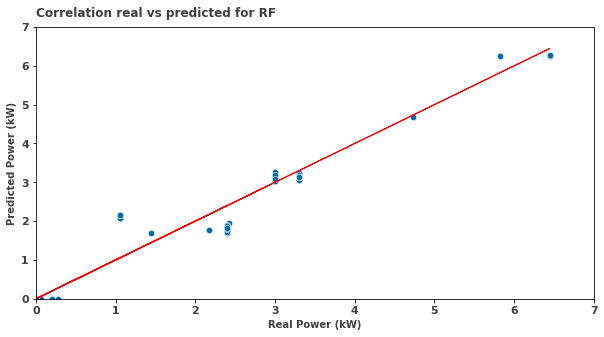

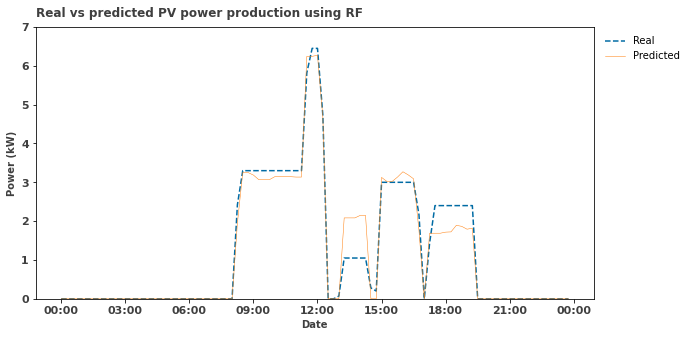

In [76]:
# Plots real vs predicted
result_plots(df_RF, 'RF')

#### Extreme Gradient Boosting (XGBoost)

[0]	validation_0-rmse:1.96935	validation_1-rmse:1.76946
[50]	validation_0-rmse:1.20414	validation_1-rmse:1.10668
[100]	validation_0-rmse:0.74886	validation_1-rmse:0.71721
[150]	validation_0-rmse:0.48471	validation_1-rmse:0.49750
[200]	validation_0-rmse:0.33972	validation_1-rmse:0.38266
[250]	validation_0-rmse:0.26731	validation_1-rmse:0.32736
[300]	validation_0-rmse:0.23494	validation_1-rmse:0.30193
[350]	validation_0-rmse:0.22160	validation_1-rmse:0.29221
[400]	validation_0-rmse:0.21624	validation_1-rmse:0.28761
[450]	validation_0-rmse:0.21400	validation_1-rmse:0.28586
[499]	validation_0-rmse:0.21292	validation_1-rmse:0.28480


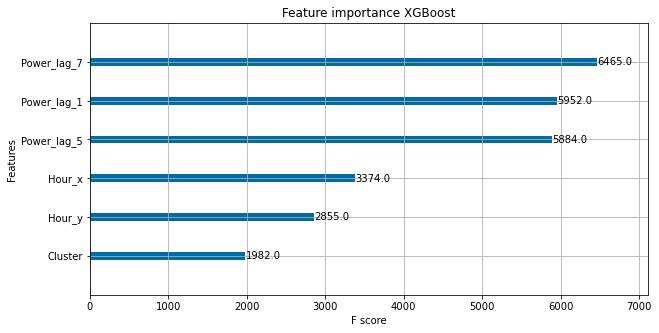

Wall time: 48.1 s


In [77]:
%%time
parameters_XGBOOST = {'n_estimators' : 500,
                      'learning_rate' : 0.01,
                      'verbosity' : 0,
                      'n_jobs' : -1,
                      'gamma' : 0,
                      'min_child_weight' : 1,
                      'max_delta_step' : 0,
                      'subsample' : 0.7,
                      'colsample_bytree' : 1,
                      'colsample_bylevel' : 1,
                      'colsample_bynode' : 1,
                      'reg_alpha' : 0,
                      'reg_lambda' : 1,
                      'random_state' : 18,
                      'objective' : 'reg:linear',
                      'booster' : 'gbtree'}

reg_XGBOOST = xgb.XGBRegressor(**parameters_XGBOOST)
reg_XGBOOST.fit(xtrain, ytrain, 
                eval_set= [(xtrain, ytrain), (xtest, ytest)],
                verbose= 50)

# Feature Importance
plot_importance(reg_XGBOOST)
plt.title("Feature importance XGBoost")
plt.show()

# Predictions and pos-processing
df_xgboost = pd.DataFrame(reg_XGBOOST.predict(xtest), columns= ['Prediction'], index= xtest.index)
df_xgboost['Real'] = ytest
df_xgboost['Prediction'] = np.where((df_xgboost['Prediction'] < 0.15 * max(df_xgboost['Prediction'])) | (df_xgboost['Prediction'] < 0), 0, df_xgboost['Prediction'])

In [78]:
# Forecasts obtained for XGBOOST
df_xgboost

Prediction  Real
Date                                 
2023-05-04 00:00:00    0.000000  0.00
2023-05-04 00:15:00    0.000000  0.00
2023-05-04 00:30:00    0.000000  0.00
2023-05-04 00:45:00    0.000000  0.00
2023-05-04 01:00:00    0.000000  0.00
2023-05-04 01:15:00    0.000000  0.00
2023-05-04 01:30:00    0.000000  0.00
2023-05-04 01:45:00    0.000000  0.00
2023-05-04 02:00:00    0.000000  0.00
2023-05-04 02:15:00    0.000000  0.00
2023-05-04 02:30:00    0.000000  0.00
2023-05-04 02:45:00    0.000000  0.00
2023-05-04 03:00:00    0.000000  0.00
2023-05-04 03:15:00    0.000000  0.00
2023-05-04 03:30:00    0.000000  0.00
2023-05-04 03:45:00    0.000000  0.00
2023-05-04 04:00:00    0.000000  0.00
2023-05-04 04:15:00    0.000000  0.00
2023-05-04 04:30:00    0.000000  0.00
2023-05-04 04:45:00    0.000000  0.00
2023-05-04 05:00:00    0.000000  0.00
2023-05-04 05:15:00    0.000000  0.00
2023-05-04 05:30:00    0.000000  0.00
2023-05-04 05:45:00    0.000000  0.00
2023-05-04 06:00:00    0.000000  0.00
2023-05-04 06:15:00    0.000000  0.00
2023-05-04 06:30:00    0.000000  0.00
2023-05-04 06:45:00    0.000000  0.00
2023-05-04 07:00:00    0.000000  0.00
2023-05-04 07:15:00    0.000000  0.00
2023-05-04 07:30:00    0.000000  0.00
2023-05-04 07:45:00    0.000000  0.00
2023-05-04 08:00:00    0.000000  0.00
2023-05-04 08:15:00    1.902607  2.42
2023-05-04 08:30:00    3.191632  3.30
2023-05-04 08:45:00    3.191632  3.30
2023-05-04 09:00:00    3.185412  3.30
2023-05-04 09:15:00    3.166471  3.30
2023-05-04 09:30:00    3.166471  3.30
2023-05-04 09:45:00    3.166471  3.30
2023-05-04 10:00:00    3.133825  3.30
2023-05-04 10:15:00    3.133825  3.30
2023-05-04 10:30:00    3.133825  3.30
2023-05-04 10:45:00    3.133825  3.30
2023-05-04 11:00:00    3.125960  3.30
2023-05-04 11:15:00    3.125960  3.30
2023-05-04 11:30:00    6.066513  5.82
2023-05-04 11:45:00    6.066513  6.45
2023-05-04 12:00:00    6.067432  6.45
2023-05-04 12:15:00    4.456511  4.73
2023-05-04 12:30:00    0.000000  0.00
2023-05-04 12:45:00    0.000000  0.00
2023-05-04 13:00:00    0.000000  0.07
2023-05-04 13:15:00    1.895186  1.05
2023-05-04 13:30:00    1.895186  1.05
2023-05-04 13:45:00    1.895186  1.05
2023-05-04 14:00:00    1.890975  1.05
2023-05-04 14:15:00    1.890975  1.05
2023-05-04 14:30:00    0.000000  0.28
2023-05-04 14:45:00    0.000000  0.20
2023-05-04 15:00:00    3.088296  3.00
2023-05-04 15:15:00    3.100047  3.00
2023-05-04 15:30:00    3.100165  3.00
2023-05-04 15:45:00    3.113371  3.00
2023-05-04 16:00:00    3.096727  3.00
2023-05-04 16:15:00    3.083934  3.00
2023-05-04 16:30:00    3.085119  3.00
2023-05-04 16:45:00    1.776964  2.17
2023-05-04 17:00:00    0.000000  0.00
2023-05-04 17:15:00    1.815788  1.44
2023-05-04 17:30:00    1.815788  2.40
2023-05-04 17:45:00    1.815788  2.40
2023-05-04 18:00:00    1.765170  2.40
2023-05-04 18:15:00    1.766806  2.40
2023-05-04 18:30:00    1.822999  2.40
2023-05-04 18:45:00    1.838654  2.40
2023-05-04 19:00:00    1.825269  2.40
2023-05-04 19:15:00    1.825422  2.40
2023-05-04 19:30:00    0.000000  0.00
2023-05-04 19:45:00    0.000000  0.00
2023-05-04 20:00:00    0.000000  0.00
2023-05-04 20:15:00    0.000000  0.00
2023-05-04 20:30:00    0.000000  0.00
2023-05-04 20:45:00    0.000000  0.00
2023-05-04 21:00:00    0.000000  0.00
2023-05-04 21:15:00    0.000000  0.00
2023-05-04 21:30:00    0.000000  0.00
2023-05-04 21:45:00    0.000000  0.00
2023-05-04 22:00:00    0.000000  0.00
2023-05-04 22:15:00    0.000000  0.00
2023-05-04 22:30:00    0.000000  0.00
2023-05-04 22:45:00    0.000000  0.00
2023-05-04 23:00:00    0.000000  0.00
2023-05-04 23:15:00    0.000000  0.00
2023-05-04 23:30:00    0.000000  0.00
2023-05-04 23:45:00    0.000000  0.00

In [79]:
# Errors
MAE_XGBOOST, RMSE_XGBOOST, normRMSE_XGBOOST, R2_XGBOOST = compute_errors(df_xgboost, ytest.Power.max())

print(f'XGBOOST - Mean Absolute Error (MAE): {MAE_XGBOOST:.2f} kW')
print(f'XGBOOST - Root Mean Square Error (RMSE): {RMSE_XGBOOST:.2f} kW')
print(f'XGBOOST - Normalized RMSE: {normRMSE_XGBOOST:.2f} %')
print(f'XGBOOST - R square: {R2_XGBOOST:.2f}')

XGBOOST - Mean Absolute Error (MAE): 0.15 kW
XGBOOST - Root Mean Square Error (RMSE): 0.28 kW
XGBOOST - Normalized RMSE: 4.42 %
XGBOOST - R square: 0.97


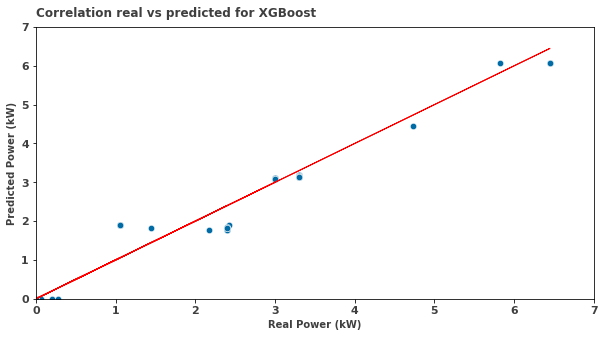

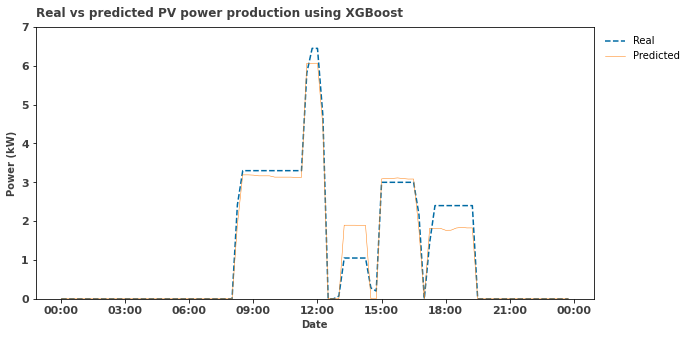

In [80]:
# Plots real vs predicted
result_plots(df_xgboost, 'XGBoost')

#### Light Gradient Boosting Machine (LightGBM)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[50]	training's rmse: 0.216438	valid_1's rmse: 0.273151


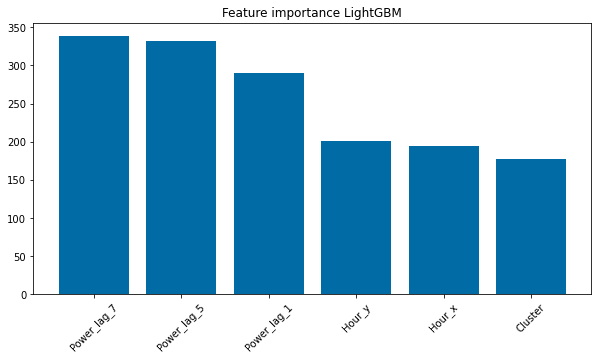

Wall time: 1.17 s


In [81]:
%%time
# Model
parameters_LGBM = {'objective': 'regression',
                   'metric': 'rmse',
                   'num_leaves': 50,
                   'learning_rate': 0.1,
                   'max_depth': 5,
                   'feature_fraction': 0.9,
                   'bagging_fraction': 0.7,
                   'bagging_freq': 10,
                   'num_iterations': 50,
                   'random_state' : 18
                  }

reg_LGBM = lgb.LGBMRegressor(**parameters_LGBM)
reg_LGBM.fit(xtrain, ytrain, 
             eval_set= [(xtrain, ytrain), (xtest, ytest)],
                verbose= 50)

# Feature importance
importances = reg_LGBM.feature_importances_
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:len(FEATURE_COLUMNS)]
x = range(len(sorted_index_top))

labels = np.array(FEATURE_COLUMNS)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label= labels)
plt.title("Feature importance LightGBM")
plt.xticks(rotation= 45)
plt.show()

# Predictions and pos-processing
df_LGBM = pd.DataFrame(reg_LGBM.predict(xtest), columns=['Prediction'], index= xtest.index)
df_LGBM['Real'] = ytest
df_LGBM['Prediction'] = np.where((df_LGBM['Prediction'] < 0.2 * max(df_LGBM['Prediction'])) | (df_LGBM['Prediction'] < 0), 0, df_LGBM['Prediction'])

In [82]:
# Forecasts obtained for LGBM
df_LGBM

Prediction  Real
Date                                 
2023-05-04 00:00:00    0.000000  0.00
2023-05-04 00:15:00    0.000000  0.00
2023-05-04 00:30:00    0.000000  0.00
2023-05-04 00:45:00    0.000000  0.00
2023-05-04 01:00:00    0.000000  0.00
2023-05-04 01:15:00    0.000000  0.00
2023-05-04 01:30:00    0.000000  0.00
2023-05-04 01:45:00    0.000000  0.00
2023-05-04 02:00:00    0.000000  0.00
2023-05-04 02:15:00    0.000000  0.00
2023-05-04 02:30:00    0.000000  0.00
2023-05-04 02:45:00    0.000000  0.00
2023-05-04 03:00:00    0.000000  0.00
2023-05-04 03:15:00    0.000000  0.00
2023-05-04 03:30:00    0.000000  0.00
2023-05-04 03:45:00    0.000000  0.00
2023-05-04 04:00:00    0.000000  0.00
2023-05-04 04:15:00    0.000000  0.00
2023-05-04 04:30:00    0.000000  0.00
2023-05-04 04:45:00    0.000000  0.00
2023-05-04 05:00:00    0.000000  0.00
2023-05-04 05:15:00    0.000000  0.00
2023-05-04 05:30:00    0.000000  0.00
2023-05-04 05:45:00    0.000000  0.00
2023-05-04 06:00:00    0.000000  0.00
2023-05-04 06:15:00    0.000000  0.00
2023-05-04 06:30:00    0.000000  0.00
2023-05-04 06:45:00    0.000000  0.00
2023-05-04 07:00:00    0.000000  0.00
2023-05-04 07:15:00    0.000000  0.00
2023-05-04 07:30:00    0.000000  0.00
2023-05-04 07:45:00    0.000000  0.00
2023-05-04 08:00:00    0.000000  0.00
2023-05-04 08:15:00    1.896277  2.42
2023-05-04 08:30:00    3.167069  3.30
2023-05-04 08:45:00    3.167069  3.30
2023-05-04 09:00:00    3.161194  3.30
2023-05-04 09:15:00    3.153888  3.30
2023-05-04 09:30:00    3.153888  3.30
2023-05-04 09:45:00    3.153888  3.30
2023-05-04 10:00:00    3.140123  3.30
2023-05-04 10:15:00    3.140123  3.30
2023-05-04 10:30:00    3.140123  3.30
2023-05-04 10:45:00    3.140123  3.30
2023-05-04 11:00:00    3.133279  3.30
2023-05-04 11:15:00    3.133279  3.30
2023-05-04 11:30:00    6.039169  5.82
2023-05-04 11:45:00    6.039169  6.45
2023-05-04 12:00:00    6.076737  6.45
2023-05-04 12:15:00    4.484895  4.73
2023-05-04 12:30:00    0.000000  0.00
2023-05-04 12:45:00    0.000000  0.00
2023-05-04 13:00:00    0.000000  0.07
2023-05-04 13:15:00    1.852927  1.05
2023-05-04 13:30:00    1.852927  1.05
2023-05-04 13:45:00    1.852927  1.05
2023-05-04 14:00:00    1.848581  1.05
2023-05-04 14:15:00    1.848581  1.05
2023-05-04 14:30:00    0.000000  0.28
2023-05-04 14:45:00    0.000000  0.20
2023-05-04 15:00:00    3.112710  3.00
2023-05-04 15:15:00    3.124501  3.00
2023-05-04 15:30:00    3.121893  3.00
2023-05-04 15:45:00    3.128024  3.00
2023-05-04 16:00:00    3.132168  3.00
2023-05-04 16:15:00    3.124556  3.00
2023-05-04 16:30:00    3.122984  3.00
2023-05-04 16:45:00    1.841687  2.17
2023-05-04 17:00:00    0.000000  0.00
2023-05-04 17:15:00    1.847226  1.44
2023-05-04 17:30:00    1.847226  2.40
2023-05-04 17:45:00    1.847226  2.40
2023-05-04 18:00:00    1.830020  2.40
2023-05-04 18:15:00    1.830020  2.40
2023-05-04 18:30:00    1.874800  2.40
2023-05-04 18:45:00    1.876461  2.40
2023-05-04 19:00:00    1.842089  2.40
2023-05-04 19:15:00    1.842089  2.40
2023-05-04 19:30:00    0.000000  0.00
2023-05-04 19:45:00    0.000000  0.00
2023-05-04 20:00:00    0.000000  0.00
2023-05-04 20:15:00    0.000000  0.00
2023-05-04 20:30:00    0.000000  0.00
2023-05-04 20:45:00    0.000000  0.00
2023-05-04 21:00:00    0.000000  0.00
2023-05-04 21:15:00    0.000000  0.00
2023-05-04 21:30:00    0.000000  0.00
2023-05-04 21:45:00    0.000000  0.00
2023-05-04 22:00:00    0.000000  0.00
2023-05-04 22:15:00    0.000000  0.00
2023-05-04 22:30:00    0.000000  0.00
2023-05-04 22:45:00    0.000000  0.00
2023-05-04 23:00:00    0.000000  0.00
2023-05-04 23:15:00    0.000000  0.00
2023-05-04 23:30:00    0.000000  0.00
2023-05-04 23:45:00    0.000000  0.00

In [83]:
# Errors
MAE_LGBM, RMSE_LGBM, normRMSE_LGBM, R2_LGBM = compute_errors(df_LGBM, ytest.Power.max())

print(f'LightGBM - Mean Absolute Error (MAE): {MAE_LGBM:.2f} W')
print(f'LightGBM - Root Mean Square Error (RMSE): {RMSE_LGBM:.2f} W')
print(f'LightGBM - Normalized RMSE: {normRMSE_LGBM:.2f} %')
print(f'LightGBM - R square: {R2_LGBM:.2f}')

LightGBM - Mean Absolute Error (MAE): 0.15 W
LightGBM - Root Mean Square Error (RMSE): 0.27 W
LightGBM - Normalized RMSE: 4.22 %
LightGBM - R square: 0.97


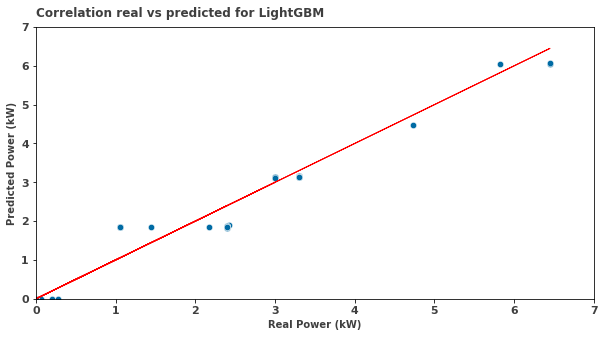

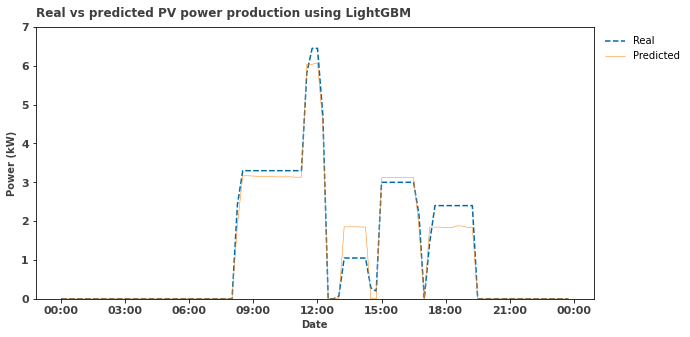

In [84]:
# Plots real vs predicted
result_plots(df_LGBM, 'LightGBM')

#### Long Short Term Memory Neural Network (LSTM-NN)

In [85]:
%%time
# Dataset with just power data, this model does not include features
data_LSTM = data_final.loc[:end_forecast][['Power']].copy()

# Configuration
with open(f'{os.getcwd()}\\conf.yml') as file:
    conf = yaml.load(file, Loader=yaml.FullLoader)
    
conf['lag'] = 96
conf['train_test_split'] = len(ytest)/len(data_LSTM)
conf['epochs'] = 10

# Model
deep_learner = DeepModelTS(data= data_LSTM , 
                            Y_var= 'Power',
                            lag= conf.get('lag'),
                            LSTM_layer_depth= conf.get('LSTM_layer_depth'),
                            epochs= conf.get('epochs'),
                            train_test_split= conf.get('train_test_split') 
                           ) 

# Fitting the model 
model = deep_learner.LSTModel()

# Predictions and pos-processing
yhat = deep_learner.predict()
yhat = [0 if x<0 else x for x in yhat]
df_lstm = data_LSTM .tail(len(yhat)).copy()
df_lstm['Prediction'] = yhat
df_lstm.rename(columns= {'Power':'Real'}, inplace= True)
df_lstm = df_lstm.reindex(columns=['Prediction', 'Real'])
df_lstm['Prediction'] = np.where((df_lstm['Prediction'] < 0.15 * max(df_lstm['Prediction'])) | (df_lstm['Prediction'] < 0), 0, df_lstm['Prediction'])

Epoch 1/10
643/643 [==============================] - 95s 142ms/step - loss: 46514520.0000 - val_loss: 1.4168
Epoch 2/10
643/643 [==============================] - 87s 135ms/step - loss: 1.5018 - val_loss: 1.2061
Epoch 3/10
643/643 [==============================] - 86s 134ms/step - loss: 1.1217 - val_loss: 0.8515
Epoch 4/10
643/643 [==============================] - 87s 136ms/step - loss: 0.6628 - val_loss: 0.6525
Epoch 5/10
643/643 [==============================] - 87s 135ms/step - loss: 0.5637 - val_loss: 0.5942
Epoch 6/10
643/643 [==============================] - 85s 133ms/step - loss: 0.5501 - val_loss: 0.5809
Epoch 7/10
643/643 [==============================] - 111s 173ms/step - loss: 0.5463 - val_loss: 0.5780
Epoch 8/10
643/643 [==============================] - 92s 142ms/step - loss: 0.5441 - val_loss: 0.5758
Epoch 9/10
643/643 [==============================] - 97s 151ms/step - loss: 0.5424 - val_loss: 0.5721
Epoch 10/10
643/643 [==============================] - 106s 165ms

In [86]:
# Forecasts obtained for LSTM
df_lstm

Prediction  Real
Date                                 
2023-05-04 00:00:00    0.000000  0.00
2023-05-04 00:15:00    0.000000  0.00
2023-05-04 00:30:00    0.000000  0.00
2023-05-04 00:45:00    0.000000  0.00
2023-05-04 01:00:00    0.000000  0.00
2023-05-04 01:15:00    0.000000  0.00
2023-05-04 01:30:00    0.000000  0.00
2023-05-04 01:45:00    0.000000  0.00
2023-05-04 02:00:00    0.000000  0.00
2023-05-04 02:15:00    0.000000  0.00
2023-05-04 02:30:00    0.000000  0.00
2023-05-04 02:45:00    0.000000  0.00
2023-05-04 03:00:00    0.000000  0.00
2023-05-04 03:15:00    0.000000  0.00
2023-05-04 03:30:00    0.000000  0.00
2023-05-04 03:45:00    0.000000  0.00
2023-05-04 04:00:00    0.000000  0.00
2023-05-04 04:15:00    0.000000  0.00
2023-05-04 04:30:00    0.000000  0.00
2023-05-04 04:45:00    0.000000  0.00
2023-05-04 05:00:00    0.000000  0.00
2023-05-04 05:15:00    0.000000  0.00
2023-05-04 05:30:00    0.000000  0.00
2023-05-04 05:45:00    0.000000  0.00
2023-05-04 06:00:00    0.000000  0.00
2023-05-04 06:15:00    0.000000  0.00
2023-05-04 06:30:00    0.000000  0.00
2023-05-04 06:45:00    0.000000  0.00
2023-05-04 07:00:00    0.000000  0.00
2023-05-04 07:15:00    0.000000  0.00
2023-05-04 07:30:00    0.000000  0.00
2023-05-04 07:45:00    0.000000  0.00
2023-05-04 08:00:00    0.000000  0.00
2023-05-04 08:15:00    0.000000  2.42
2023-05-04 08:30:00    2.907854  3.30
2023-05-04 08:45:00    3.430983  3.30
2023-05-04 09:00:00    3.175563  3.30
2023-05-04 09:15:00    3.118375  3.30
2023-05-04 09:30:00    3.124866  3.30
2023-05-04 09:45:00    3.140664  3.30
2023-05-04 10:00:00    3.189207  3.30
2023-05-04 10:15:00    3.232400  3.30
2023-05-04 10:30:00    3.269456  3.30
2023-05-04 10:45:00    3.289111  3.30
2023-05-04 11:00:00    3.301884  3.30
2023-05-04 11:15:00    3.307489  3.30
2023-05-04 11:30:00    3.310450  5.82
2023-05-04 11:45:00    6.380764  6.45
2023-05-04 12:00:00    6.509307  6.45
2023-05-04 12:15:00    6.363245  4.73
2023-05-04 12:30:00    4.071250  0.00
2023-05-04 12:45:00    0.000000  0.00
2023-05-04 13:00:00    0.000000  0.07
2023-05-04 13:15:00    0.000000  1.05
2023-05-04 13:30:00    1.531688  1.05
2023-05-04 13:45:00    1.314755  1.05
2023-05-04 14:00:00    1.317242  1.05
2023-05-04 14:15:00    1.277352  1.05
2023-05-04 14:30:00    1.254782  0.28
2023-05-04 14:45:00    0.000000  0.20
2023-05-04 15:00:00    0.000000  3.00
2023-05-04 15:15:00    3.498407  3.00
2023-05-04 15:30:00    3.015404  3.00
2023-05-04 15:45:00    3.017135  3.00
2023-05-04 16:00:00    2.941919  3.00
2023-05-04 16:15:00    2.931633  3.00
2023-05-04 16:30:00    2.920860  3.00
2023-05-04 16:45:00    2.936452  2.17
2023-05-04 17:00:00    2.028925  0.00
2023-05-04 17:15:00    0.000000  1.44
2023-05-04 17:30:00    1.829915  2.40
2023-05-04 17:45:00    2.667669  2.40
2023-05-04 18:00:00    2.546573  2.40
2023-05-04 18:15:00    2.509244  2.40
2023-05-04 18:30:00    2.481249  2.40
2023-05-04 18:45:00    2.458546  2.40
2023-05-04 19:00:00    2.449526  2.40
2023-05-04 19:15:00    2.448416  2.40
2023-05-04 19:30:00    2.451952  0.00
2023-05-04 19:45:00    0.000000  0.00
2023-05-04 20:00:00    0.000000  0.00
2023-05-04 20:15:00    0.000000  0.00
2023-05-04 20:30:00    0.000000  0.00
2023-05-04 20:45:00    0.000000  0.00
2023-05-04 21:00:00    0.000000  0.00
2023-05-04 21:15:00    0.000000  0.00
2023-05-04 21:30:00    0.000000  0.00
2023-05-04 21:45:00    0.000000  0.00
2023-05-04 22:00:00    0.000000  0.00
2023-05-04 22:15:00    0.000000  0.00
2023-05-04 22:30:00    0.000000  0.00
2023-05-04 22:45:00    0.000000  0.00
2023-05-04 23:00:00    0.000000  0.00
2023-05-04 23:15:00    0.000000  0.00
2023-05-04 23:30:00    0.000000  0.00
2023-05-04 23:45:00    0.000000  0.00

In [87]:
# Errors
MAE_LSTM, RMSE_LSTM, normRMSE_LSTM, R2_LSTM = compute_errors(df_lstm, df_lstm.Real.max())

print(f'LSTM - Mean Absolute Error (MAE): {MAE_LSTM:.2f} W')
print(f'LSTM - Root Mean Square Error (RMSE): {RMSE_LSTM:.2f} W')
print(f'LSTM - Normalized RMSE: {normRMSE_LSTM:.2f} %')
print(f'LSTM - R square: {R2_LSTM:.2f}')

LSTM - Mean Absolute Error (MAE): 0.29 W
LSTM - Root Mean Square Error (RMSE): 0.77 W
LSTM - Normalized RMSE: 11.92 %
LSTM - R square: 0.78


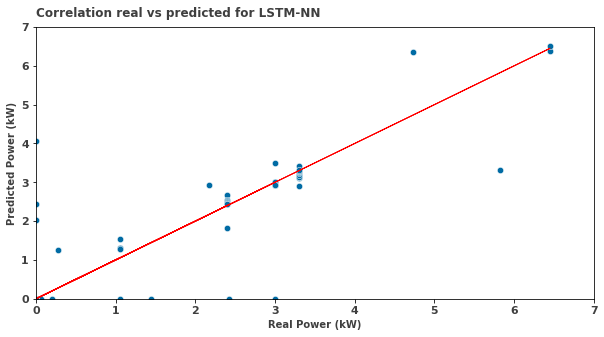

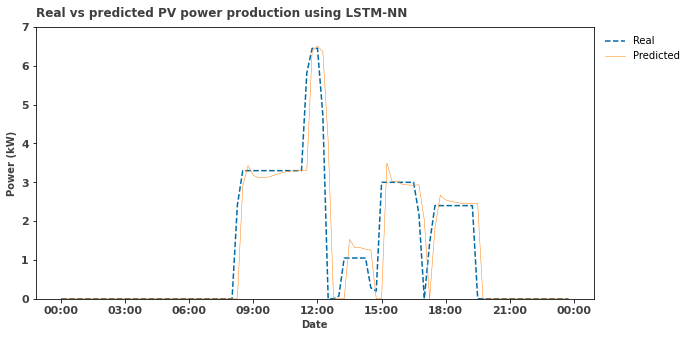

In [88]:
# Plots real vs predicted
result_plots(df_lstm, 'LSTM-NN')

#### Stacking

In [89]:
%%time
# Metalearner 
meta = lgb.LGBMRegressor(**parameters_LGBM)

# Stacking model 
stack = StackingCVRegressor(regressors= (reg_LGBM, reg_XGBOOST),
                            meta_regressor= meta, cv= 5,
                            use_features_in_secondary= True,
                            store_train_meta_features= True,
                            shuffle= False,
                            verbose= 0,
                            random_state= 18)

stack.fit(xtrain, ytrain)

# The names of the features has to be f+num_features
xtest_stack = xtest.copy()
xtest_stack.columns= ['f'+str(i) for i in range(0, len(FEATURE_COLUMNS))]

# Predictions and pos-processing
df_stack = pd.DataFrame(stack.predict(xtest_stack), columns= ['Prediction'], index= xtest_stack.index)
df_stack['Real'] = ytest
df_stack['Prediction'] = np.where(df_stack['Prediction'] < 0, 0 , df_stack['Prediction'])

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

In [90]:
# Forecasts obtained for Stacking
df_stack

Prediction  Real
Date                                 
2023-05-04 00:00:00    0.001766  0.00
2023-05-04 00:15:00    0.001766  0.00
2023-05-04 00:30:00    0.001766  0.00
2023-05-04 00:45:00    0.001766  0.00
2023-05-04 01:00:00    0.001766  0.00
2023-05-04 01:15:00    0.001766  0.00
2023-05-04 01:30:00    0.009905  0.00
2023-05-04 01:45:00    0.006706  0.00
2023-05-04 02:00:00    0.006233  0.00
2023-05-04 02:15:00    0.006233  0.00
2023-05-04 02:30:00    0.006233  0.00
2023-05-04 02:45:00    0.006233  0.00
2023-05-04 03:00:00    0.006233  0.00
2023-05-04 03:15:00    0.006233  0.00
2023-05-04 03:30:00    0.006233  0.00
2023-05-04 03:45:00    0.006233  0.00
2023-05-04 04:00:00    0.006233  0.00
2023-05-04 04:15:00    0.006233  0.00
2023-05-04 04:30:00    0.006233  0.00
2023-05-04 04:45:00    0.006233  0.00
2023-05-04 05:00:00    0.008021  0.00
2023-05-04 05:15:00    0.008021  0.00
2023-05-04 05:30:00    0.008021  0.00
2023-05-04 05:45:00    0.008021  0.00
2023-05-04 06:00:00    0.008232  0.00
2023-05-04 06:15:00    0.008232  0.00
2023-05-04 06:30:00    0.008232  0.00
2023-05-04 06:45:00    0.027187  0.00
2023-05-04 07:00:00    0.014758  0.00
2023-05-04 07:15:00    0.014758  0.00
2023-05-04 07:30:00    0.014758  0.00
2023-05-04 07:45:00    0.040099  0.00
2023-05-04 08:00:00    0.031630  0.00
2023-05-04 08:15:00    1.889621  2.42
2023-05-04 08:30:00    3.146369  3.30
2023-05-04 08:45:00    3.146369  3.30
2023-05-04 09:00:00    3.146369  3.30
2023-05-04 09:15:00    3.163334  3.30
2023-05-04 09:30:00    3.163334  3.30
2023-05-04 09:45:00    3.163334  3.30
2023-05-04 10:00:00    3.140350  3.30
2023-05-04 10:15:00    3.140350  3.30
2023-05-04 10:30:00    3.140350  3.30
2023-05-04 10:45:00    3.140350  3.30
2023-05-04 11:00:00    3.141855  3.30
2023-05-04 11:15:00    3.141855  3.30
2023-05-04 11:30:00    6.073722  5.82
2023-05-04 11:45:00    6.073722  6.45
2023-05-04 12:00:00    6.064708  6.45
2023-05-04 12:15:00    4.453217  4.73
2023-05-04 12:30:00    0.029540  0.00
2023-05-04 12:45:00    0.027023  0.00
2023-05-04 13:00:00    0.030313  0.07
2023-05-04 13:15:00    1.889196  1.05
2023-05-04 13:30:00    1.889196  1.05
2023-05-04 13:45:00    1.889196  1.05
2023-05-04 14:00:00    1.891865  1.05
2023-05-04 14:15:00    1.891865  1.05
2023-05-04 14:30:00    0.032381  0.28
2023-05-04 14:45:00    0.024137  0.20
2023-05-04 15:00:00    3.106695  3.00
2023-05-04 15:15:00    3.095139  3.00
2023-05-04 15:30:00    3.095139  3.00
2023-05-04 15:45:00    3.095139  3.00
2023-05-04 16:00:00    3.092683  3.00
2023-05-04 16:15:00    3.104239  3.00
2023-05-04 16:30:00    3.104239  3.00
2023-05-04 16:45:00    1.771639  2.17
2023-05-04 17:00:00    0.027957  0.00
2023-05-04 17:15:00    1.835389  1.44
2023-05-04 17:30:00    1.835389  2.40
2023-05-04 17:45:00    1.835389  2.40
2023-05-04 18:00:00    1.797695  2.40
2023-05-04 18:15:00    1.797695  2.40
2023-05-04 18:30:00    1.838918  2.40
2023-05-04 18:45:00    1.838918  2.40
2023-05-04 19:00:00    1.838918  2.40
2023-05-04 19:15:00    1.838918  2.40
2023-05-04 19:30:00    0.041738  0.00
2023-05-04 19:45:00    0.042458  0.00
2023-05-04 20:00:00    0.041772  0.00
2023-05-04 20:15:00    0.046193  0.00
2023-05-04 20:30:00    0.041772  0.00
2023-05-04 20:45:00    0.039322  0.00
2023-05-04 21:00:00    0.046223  0.00
2023-05-04 21:15:00    0.021573  0.00
2023-05-04 21:30:00    0.021573  0.00
2023-05-04 21:45:00    0.021573  0.00
2023-05-04 22:00:00    0.012227  0.00
2023-05-04 22:15:00    0.024919  0.00
2023-05-04 22:30:00    0.009274  0.00
2023-05-04 22:45:00    0.009274  0.00
2023-05-04 23:00:00    0.009274  0.00
2023-05-04 23:15:00    0.009274  0.00
2023-05-04 23:30:00    0.009274  0.00
2023-05-04 23:45:00    0.009274  0.00

In [91]:
# Errors
MAE_STACKING, RMSE_STACKING, normRMSE_STACKING, R2_STACKING = compute_errors(df_stack, ytest.Power.max())

print(f'STACKING - Mean Absolute Error (MAE): {MAE_STACKING:.2f} W')
print(f'STACKING - Root Mean Square Error (RMSE): {RMSE_STACKING:.2f} W')
print(f'STACKING - Normalized RMSE: {normRMSE_STACKING:.2f} %')
print(f'STACKING - R square: {R2_STACKING:.2f}')

STACKING - Mean Absolute Error (MAE): 0.16 W
STACKING - Root Mean Square Error (RMSE): 0.28 W
STACKING - Normalized RMSE: 4.37 %
STACKING - R square: 0.97


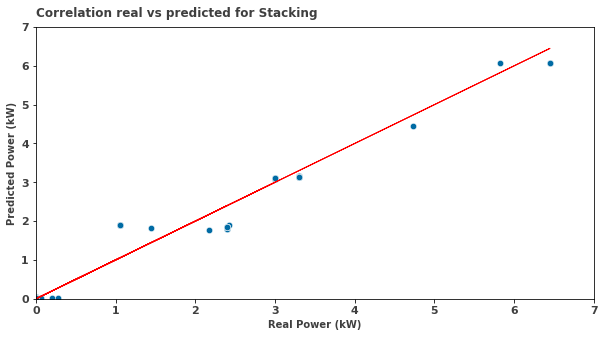

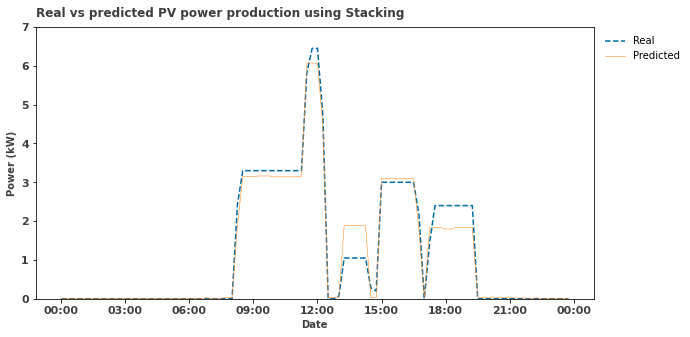

In [92]:
# Plots real vs predicted
result_plots(df_stack, 'Stacking')

### Summary

In [95]:
results = {'Model' : ['MLR', 'DT', 'RF', 'LSTM','XGBOOST', 'LightGBM', 'Stacking'], 
           'NRMSE (%)' : [normRMSE_LR, normRMSE_DT, normRMSE_RF, normRMSE_LSTM, normRMSE_XGBOOST, normRMSE_LGBM, normRMSE_STACKING],
           'MAE (W)' : [MAE_LR, MAE_DT, MAE_RF, MAE_LSTM, MAE_XGBOOST, MAE_LGBM, MAE_STACKING],
           'R2' : [R2_LR, R2_DT, R2_RF, R2_LSTM, R2_XGBOOST, R2_LGBM, R2_STACKING],
           'Execution Time (s)' : [0.2, 0.5, 180, 780, 50, 5, 150]}

summary = pd.DataFrame(data= results)
summary = summary.round(2)
summary = summary [:-1]
summary_sorted = summary.sort_values('NRMSE (%)')

summary_sorted

Model  NRMSE (%)  MAE (W)    R2  Execution Time (s)
5  LightGBM       4.22     0.15  0.97                 5.0
4   XGBOOST       4.42     0.15  0.97                50.0
1        DT       4.80     0.16  0.96                 0.5
2        RF       5.03     0.16  0.96               180.0
3      LSTM      11.92     0.29  0.78               780.0
0       MLR      21.94     0.72  0.26                 0.2

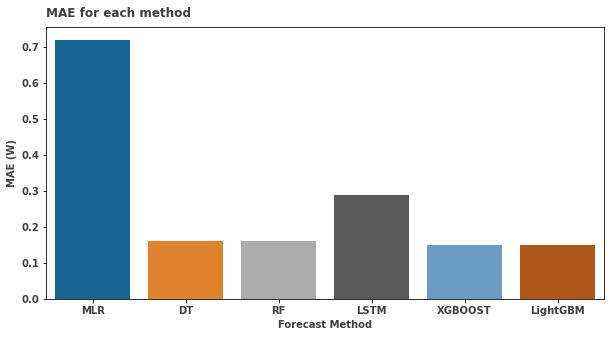

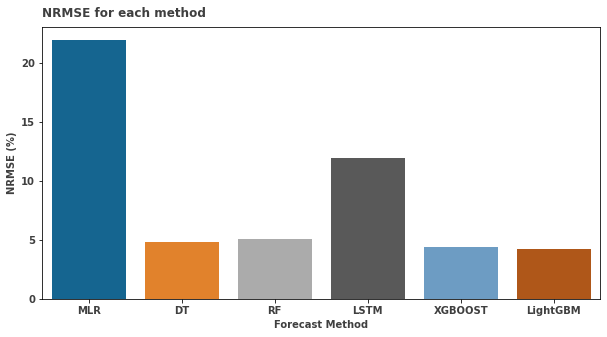

In [96]:
# MAE
sns.barplot(data= summary, x= 'Model', y= 'MAE (W)')
plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")
plt.xlabel("Forecast Method",alpha=0.75, weight="bold")
plt.ylabel("MAE (W)",alpha=0.75, weight="bold")
plt.title("MAE for each method", alpha=0.75, weight="bold", loc="left", pad=10)
plt.show()

# NRMSE
sns.barplot(data= summary, x= 'Model', y= 'NRMSE (%)')
plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")
plt.xlabel("Forecast Method",alpha=0.75, weight="bold")
plt.ylabel("NRMSE (%)",alpha=0.75, weight="bold")
plt.title("NRMSE for each method", alpha=0.75, weight="bold", loc="left", pad=10)
plt.show()

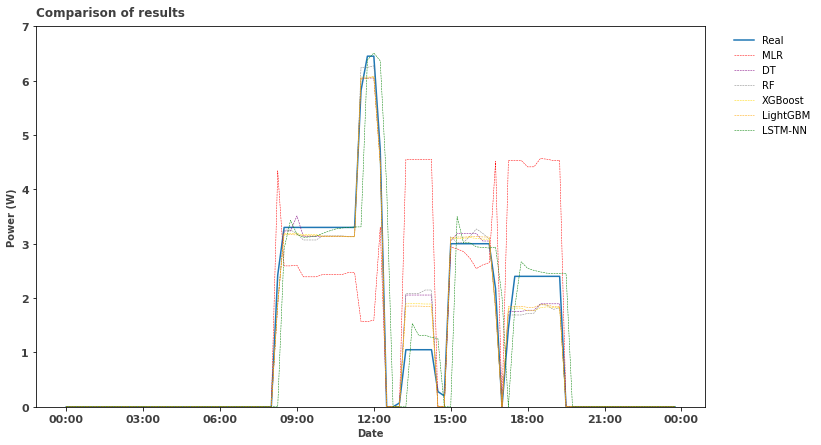

In [97]:
# Comparison of results for the forecast day
day = '2023-05-04'

lr = df_LR[day]
dt = df_DT[day]
rf = df_RF[day]
xgboost = df_xgboost[day]
lgbm = df_LGBM[day]
lstm = df_lstm[day]
stacking = df_stack[day]

# Plot
colors = ["Red", "Green", "#1f77b4", "Orange", 'Gold', "Purple", "Gray"]
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(x= lr.index, y= lr.Real, label= 'Real', ax= ax, color= colors[2])
sns.lineplot(x= lr.index, y= lr.Prediction, label= 'MLR', ax= ax, linewidth= 0.5, linestyle = "dashed", color= colors[0])
sns.lineplot(x= dt.index, y= dt.Prediction, label= 'DT', ax= ax, linewidth= 0.5, linestyle = "dashed", color= colors[5])
sns.lineplot(x= rf.index, y= rf.Prediction, label= 'RF', ax= ax, linewidth= 0.5, linestyle = "dashed", color= colors[6])
sns.lineplot(x= xgboost.index, y= xgboost.Prediction, label= 'XGBoost', ax= ax, linewidth= 0.5, linestyle = "dashed", color= colors[4])
sns.lineplot(x= lgbm.index, y= lgbm.Prediction, label= 'LightGBM', ax= ax, linewidth= 0.5, linestyle = "dashed", color= colors[3])
sns.lineplot(x= lstm.index, y= lstm.Prediction, label= 'LSTM-NN', ax= ax, linewidth= 0.5, linestyle = "dashed", color= colors[1])
#sns.lineplot(x= stacking.index, y= stacking.Prediction, label= 'Stacking', ax= ax, linewidth= 0.5, linestyle = "dashed", color= colors[5])
plt.xlabel("Date", alpha= 0.75, weight= "bold")
plt.ylabel("Power (W)", alpha= 0.75, weight= "bold")
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.legend(frameon= False, bbox_to_anchor=(1.17, 1))
plt.title('Comparison of results', alpha= 0.75, weight= "bold", pad= 10, loc= "left")
plt.gca().xaxis.set_major_formatter(date_format)
plt.ylim(0,7)
plt.show()

### Best Results (LightGBM)

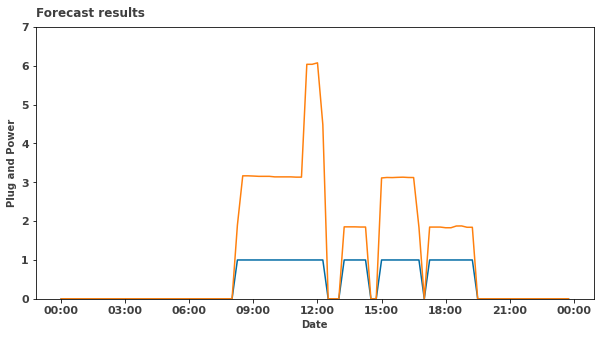

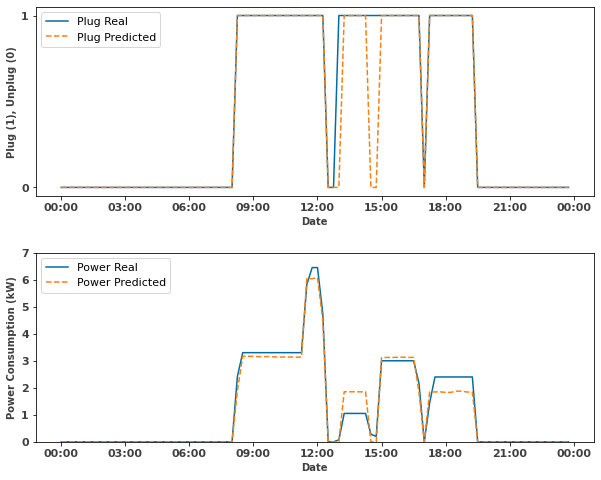

In [98]:
df_results = df_cla.copy()
df_results['Power Prediction'] = df_LGBM.Prediction
df_results['Power Real'] = df_LGBM.Real
df_results.rename(columns= {'Real': 'Plug Real', 'Prediction': 'Plug Prediction'}, inplace= True)

# Plot of both forecasts
fig, ax1 = plt.subplots()
ax1.plot(df_results.index, df_results["Plug Prediction"], label= "Plug")
ax1.plot(df_results.index, df_results["Power Prediction"], label= "Power")
plt.gca().xaxis.set_major_formatter(date_format)
ax1.set_xlabel("Date", alpha= 0.75, weight= "bold")
ax1.set_ylabel("Plug and Power", alpha= 0.75, weight= "bold")
ax1.set_title('Forecast results', alpha= 0.75, weight= "bold", pad= 10, loc= "left")
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.ylim(0,7)
plt.show()

# Individual plots for Plug and Power
fig = plt.figure(figsize= (10, 8))
plt.subplots_adjust(hspace=0.3)

ax2 = fig.add_subplot(2, 1, 1)
ax2.plot(df_results.index, df_results["Plug Real"], label= "Plug Real")
ax2.plot(df_results.index, df_results["Plug Prediction"],label= "Plug Predicted", linestyle="dashed")
ax2.set_xlabel("Date", alpha= 0.75, weight= "bold")
ax2.set_ylabel("Plug (1), Unplug (0)", alpha= 0.75, weight= "bold")
ax2.legend(frameon= False, bbox_to_anchor=(1.22, 1))
#ax2.set_title('Plug', alpha= 0.75, weight= "bold", pad= 10, loc= "left")
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks([0,1], alpha= 0.75, weight= "bold", fontsize= 11)
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend(fontsize= 11, loc= 'upper left')

ax3 = fig.add_subplot(2, 1, 2)
ax3.plot(df_results.index, df_results["Power Real"], label= "Power Real")
ax3.plot(df_results.index, df_results["Power Prediction"], label= "Power Predicted", linestyle="dashed")
ax3.set_xlabel("Date", alpha= 0.75, weight= "bold")
ax3.set_ylabel("Power Consumption (kW)", alpha= 0.75, weight= "bold")
ax3.legend(frameon= False, bbox_to_anchor=(1.24, 1))
#ax3.set_title('Power', alpha= 0.75, weight= "bold", pad= 10, loc= "left")
plt.xticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.yticks(alpha= 0.75, weight= "bold", fontsize= 11)
plt.ylim(0,7)
plt.gca().xaxis.set_major_formatter(date_format)
plt.legend(fontsize= 11, loc= 'upper left')

# Show the figure
plt.show()